In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import os
from tqdm import tqdm

In [2]:
sns.set("notebook", style="white")

### Height and gravity

In [3]:
delta_t = 2
x_space = np.linspace(-2, 2, 32)
velocity_space = np.linspace(-3, 3, 32)
x_plot = np.linspace(-2, 2, 1000)

In [4]:
def height(x):
    
    if x <= 0:
        y = x**2 + x + 0.25
    else:
        y = x*(1+5*x**2)**(-1/2) + (1/32)*(x**4) + 0.25
    
    return y

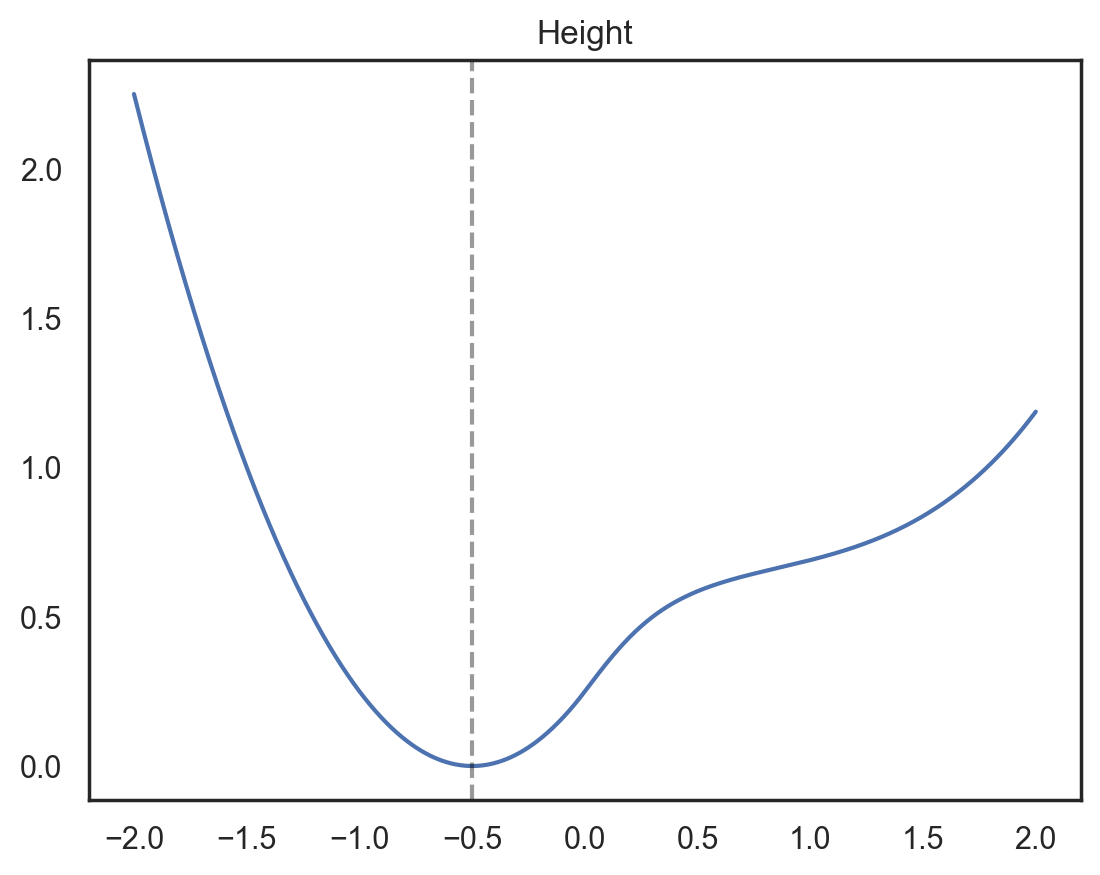

In [5]:
fig, ax = plt.subplots()
ax.plot(x_plot, [height(x) for x in x_plot])
ax.set_title("Height")
ax.axvline(-0.5, linestyle="--", color="black", alpha=0.4);

In [6]:
def phi(x):
    phi = np.zeros_like(x)
    is_leq0 = x<=0
    phi_1 = 2*x+1
    a = (1 + 5*x**2)
    phi_2 = a**(-0.5)
    phi_3 = - 5*x**2*a**(-1.5)
    phi_4 = (x/2)**4 # negative of paper
    phi = phi_2 + phi_3 + phi_4
    phi[is_leq0] = phi_1[is_leq0]  
    return - phi
#     if x <= 0:
#         return -2*x - 1
#     else:
#         return # (1+5*x**2)**(-1/2)- 5*x**2*(1+5*x**2)**(-3/2) + 0.5*x**4 
#         # -(1+5*x**2)**(-3/2) - (1/8)*x**3

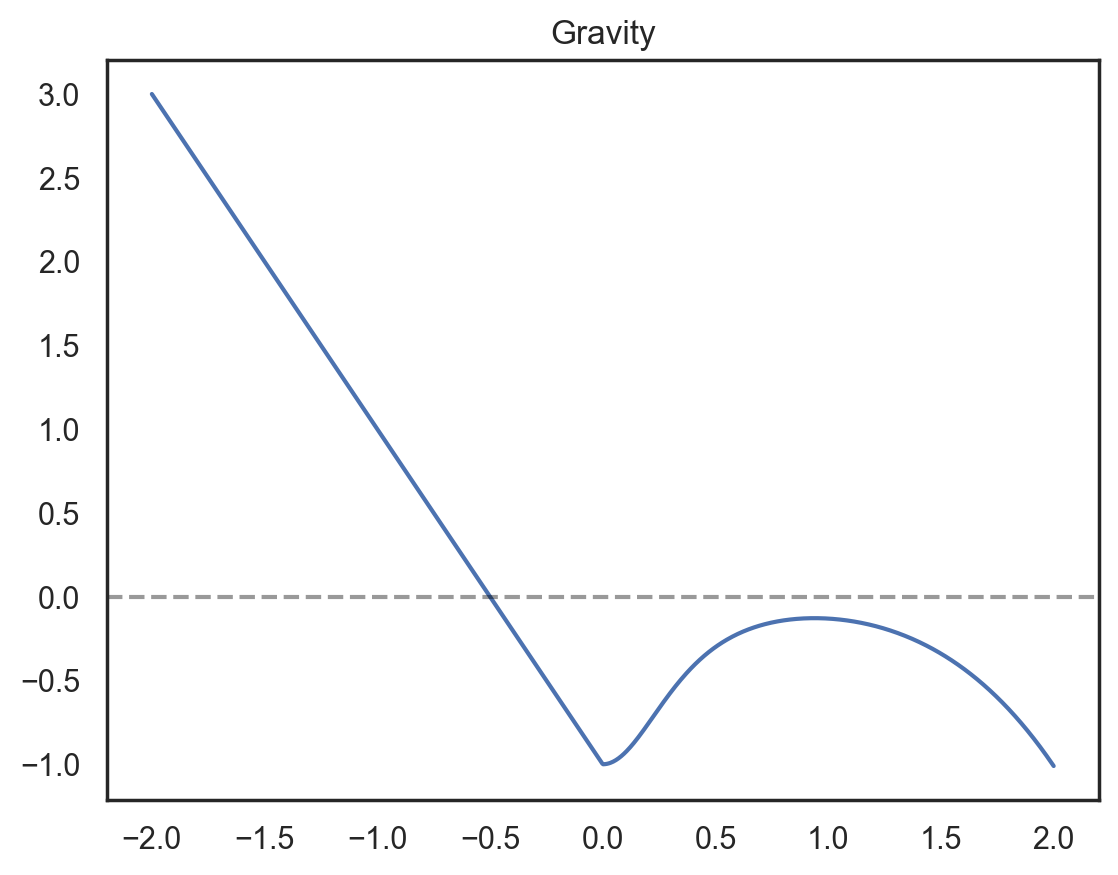

In [7]:
fig, ax = plt.subplots()
ax.plot(x_plot, phi(x_plot))
ax.axhline(0, linestyle="--", color="black", alpha=0.4)
ax.set_title("Gravity");

In [8]:
def update_position_and_velocity(position, velocity, action):
    force_action = np.tanh(action)
    force_friction = -(1/8) * velocity
    force_gravity = phi(position)
    force = force_gravity + force_friction + force_action
    velocity += force
    position += velocity
    return position, velocity

## Gym

In [9]:
import gym

In [10]:
env = gym.make("MountainCar-v0")

In [11]:
env.reset()

array([-0.5065563,  0.       ], dtype=float32)

In [12]:
env.step(2)

(array([-0.505684  ,  0.00087224], dtype=float32), -1.0, False, {})

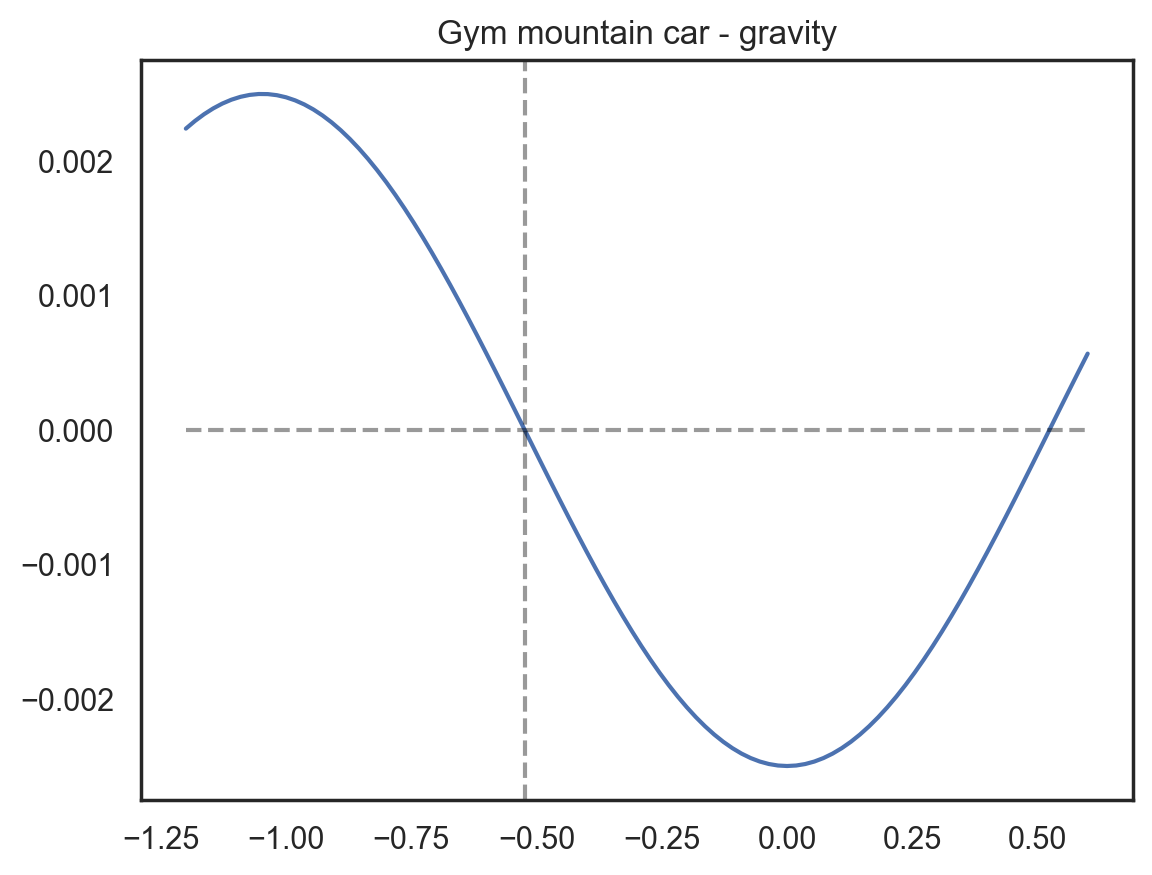

In [13]:
x_gym = np.linspace(-1.2, 0.6, 100)

fig, ax = plt.subplots()
ax.plot(x_gym, -0.0025 * np.cos(3*x_gym))
ax.axvline(-np.pi/6, linestyle="--", color="black", alpha=0.4)
ax.hlines(0., xmin=x_gym[0], xmax=x_gym[-1], linestyle="--", color="black", alpha=0.4)
ax.set_title("Gym mountain car - gravity");

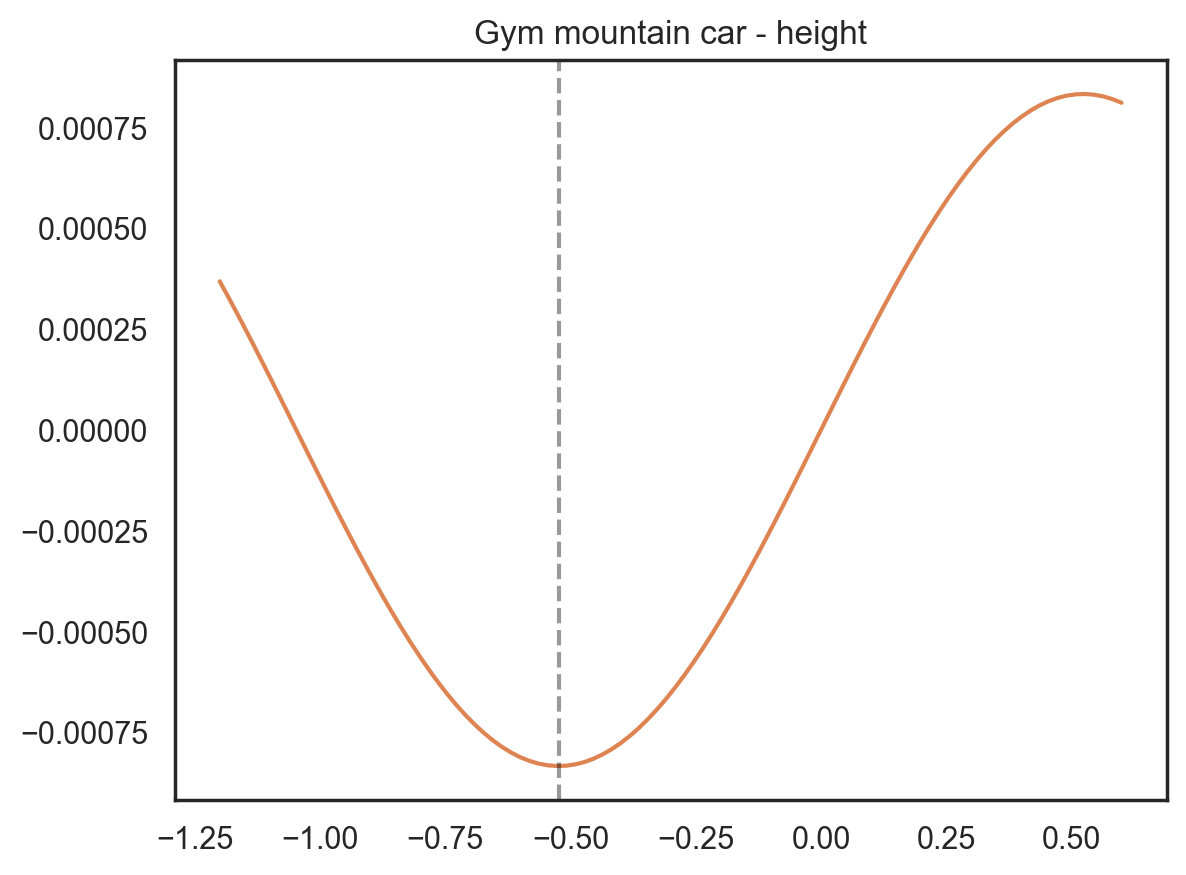

In [14]:
fig, ax = plt.subplots()
ax.plot(x_gym, np.sin(3*x_gym)/1200, color="C1")
ax.axvline(-np.pi/6, linestyle="--", color="black", alpha=0.4)
ax.set_title("Gym mountain car - height");

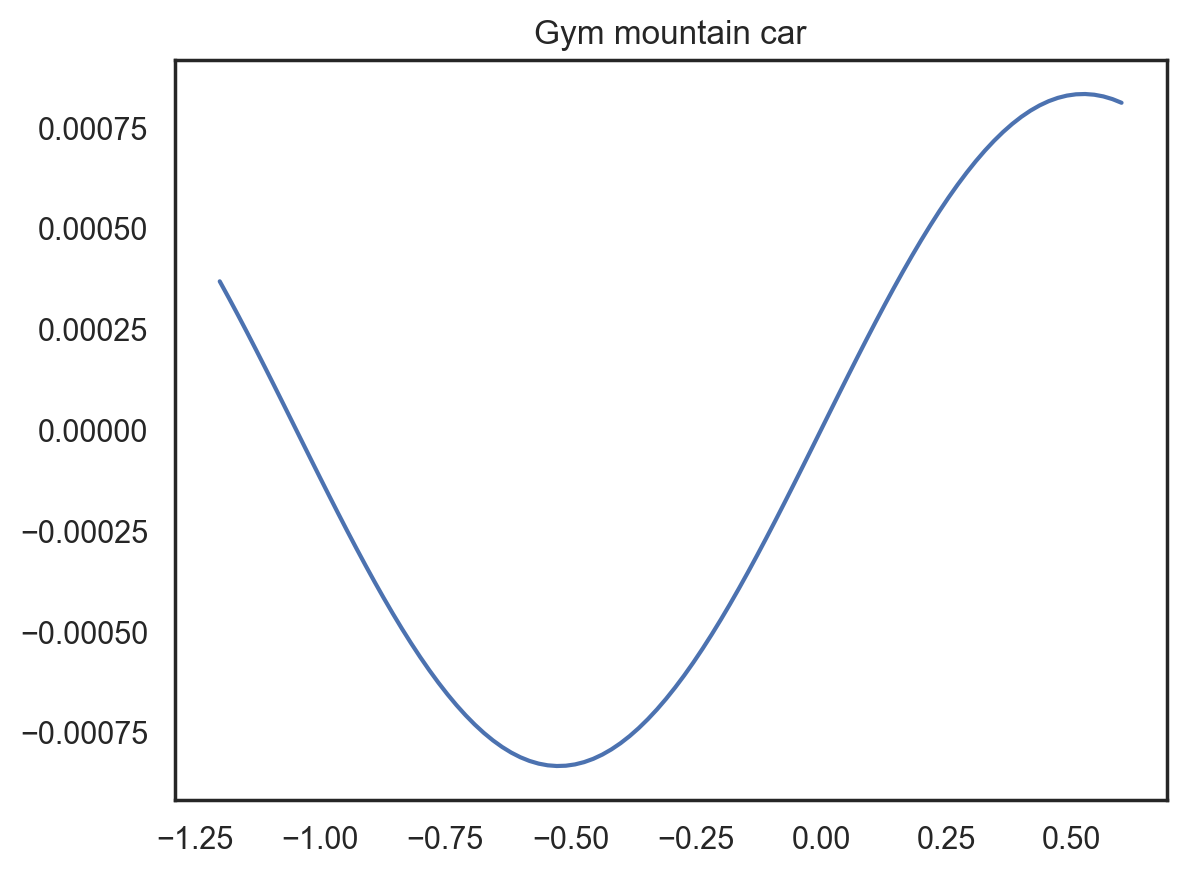

In [15]:
fig, ax = plt.subplots()
ax.plot(x_gym, np.sin(3*x_gym)/1200)
ax.set_title("Gym mountain car");

In [16]:
def dynamics_gym(position, velocity, action, gravity=0.0025, force=0.001):
    assert action in [-1, 0, 1], "Action needs to be either -1, 0, or 1"
    velocity += action*force - np.cos(3 * position) * gravity
    position += velocity
    return position, velocity

In [17]:
position, velocity = -np.pi/6, 0
actions = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1] 
for i, action in enumerate(actions):
    position, velocity = dynamics_gym(position, velocity, action)
    velocity = np.clip(velocity, -0.07, 0.07)
    position = np.clip(position, -1.2, 0.6)
    print(i, action, position, velocity)

0 1 -0.5225987755982988 0.0009999999999999998
1 1 -0.5206062755870489 0.0019925000112499943
2 1 -0.5176362190244069 0.0029700565626419734
3 1 -0.5137108792513178 0.003925339773089185
4 1 -0.5088596878254337 0.004851191425884095
5 1 -0.5031190035396563 0.00574068428577737
6 1 -0.4965318209290182 0.006587182610638135
7 1 -0.48914741746676027 0.007384403462257964
8 1 -0.4810209394215762 0.008126478045184092
9 1 -0.47221292748890664 0.00880801193266958


## Backward motion

#### Old motion Implementation

In [18]:
# def forward_motion(motion, action, delta_t, scale_gravity, scale_friction):
    
#     def _equations_of_motion(t, x, *args):
#         action,  = args
#         position, velocity = x

#         force_action = np.tanh(action)

#         force_friction = -scale_friction * velocity

#         if position <= 0:
#             force_gravity = -2*position - 1
#         else:
#             # force_gravity = - position**2*(1+5*position**2)**(-3/2) - (1/8)*position**4
#             force_gravity = -(1+5*position**2)**(-3/2) - (1/8)*position**3

#         force_gravity *= scale_gravity # Scale it

#         force = force_gravity + force_friction + force_action
#         change_in_velocity = force
#         change_in_position = velocity
        
#         if (velocity >= 3 and change_in_velocity > 0) \
#                 or (velocity <= -3 and change_in_velocity < 0):
#             change_in_velocity = 0
        
#         if (position <= -2 and change_in_position < 0) \
#                 or (position >= 2 and change_in_position > 0):
#             change_in_position = 0
#             change_in_velocity = - velocity # zeroing out velocity
            
#         dy = np.array([change_in_position, change_in_velocity])
#         return dy
    
# #     def _bounds(t, y):
# #         position, velocity = y.reshape((2,))
# #         if position <= -2 or position >=2 or velocity <= -3 or velocity >= 3
# #             return True
# #         else:
# #             return False
    
#     sol = scipy.integrate.solve_ivp(
#         fun=_equations_of_motion, 
#         y0=motion,
#         args=(action, ), 
#         t_span=[0, delta_t, ],
#         t_eval=[delta_t, ])
#         # events=_bounds)
    
#     position, velocity =  sol.y.reshape((2,))
#     position = np.clip(position, -2, 2)
#     velocity = np.clip(velocity, -3, 3)
#     return np.array([position, velocity])

#### New implementation

In [19]:
def plot_belief(b, fig=None, ax=None, colorbar=True, cmap="gray"):
    
    if fig is None or ax is None:
        fig, ax = plt.subplots()
    pos = ax.imshow(
        b.reshape(len(position_space), len(velocity_space)), 
        origin="lower", 
        extent=(min(position_space), max(position_space),
                min(velocity_space), max(velocity_space)),
        aspect=(max(position_space)-min(position_space)) 
            /(max(velocity_space)-min(velocity_space)),
        cmap=cmap)
    ax.set_xlabel("position")
    ax.set_ylabel("velocity")
    if colorbar:
        fig.colorbar(pos)

In [22]:
delta_t = 1.
scale_gravity = 0.44
scale_friction = 0.25 # 0.04 # 0.125 # 1/8
scale_action = 0.25
scale_position = 0.5
position_space = np.linspace(-2, 2, 32)
velocity_space = np.linspace(-3, 3, 32)
action_space = np.arange(-2, 3) 
kernel = np.array([1/4, 1/2, 1/4]).reshape((-1,1))

def forward_motion(motion, action, delta_t, 
                   scale_gravity, scale_friction, scale_action, scale_position):
    
    position, velocity = motion

    force_action = scale_action * np.tanh(action)

    force_friction = -scale_friction * velocity

    if position <= 0:
        force_gravity = -2*position - 1
    else:
        a = (1 + 5*position**2)
        phi_2 = a**(-0.5)
        phi_3 = - 5*position**2*a**(-1.5)
        phi_4 = (position/2)**4 # negative of paper
        phi = phi_2 + phi_3 + phi_4
        # force_gravity = - position**2*(1+5*position**2)**(-3/2) - (1/8)*position**4
        # force_gravity = -(1+5*position**2)**(-3/2) - (1/8)*position**3
        force_gravity = -phi
        
    force_gravity *= scale_gravity # Scale it

    force = force_gravity + force_friction + force_action
    change_in_velocity = force
    change_in_position = scale_position*velocity

    if (velocity >= 3 and change_in_velocity > 0) \
            or (velocity <= -3 and change_in_velocity < 0):
        change_in_velocity = 0

    if (position <= -2 and change_in_position < 0) \
            or (position >= 2 and change_in_position > 0):
        change_in_position = 0
        change_in_velocity = - velocity # zeroing out velocity
    
    position += change_in_position
    velocity += change_in_velocity
    
    position = np.clip(position, -2, 2)
    velocity = np.clip(velocity, -3, 3)
    return np.array([position, velocity])

coords = np.dstack(np.meshgrid(position_space, velocity_space)).reshape(-1, 2)
n_state = len(position_space) * len(velocity_space)
n_action = len(action_space)   

p_forward = np.zeros((n_action, n_state, n_state))

tree = scipy.spatial.KDTree(coords)

for idx_act in range(n_action):
    for idx, coord in enumerate(coords):
        
        act = action_space[idx_act]
        
        expected_motion = forward_motion(
            motion=coord,
            action=act, 
            delta_t=delta_t,
            scale_gravity=scale_gravity,
            scale_friction=scale_friction,
            scale_action=scale_action,
            scale_position=scale_position)
        
        dist, idx_closest = tree.query(expected_motion)
        
        s = np.zeros(n_state)
        s[idx_closest] = 1.
        
        # Do the convolution
        s = s.reshape((len(position_space), len(velocity_space)))
        s = scipy.signal.convolve(s, kernel, mode="same")
        s = scipy.signal.convolve(s, kernel.T, mode="same")
        s = s.ravel()
        
        p_forward[idx_act, idx, :] =  s
        p_forward[idx_act, idx, :] /= p_forward[idx_act, idx, :].sum()
        
p_backward = np.zeros_like(p_forward)
for idx_act in range(n_action):
    p_backward[idx_act] = p_forward[idx_act]
    for idx in range(n_state):
        bwd_sum = p_backward[idx_act, :, idx].sum()
        if bwd_sum > 0:
            p_backward[idx_act, :, idx] /= bwd_sum # Normalize

In [24]:
n_steps_variations = [0, 4, 8]

belief_plot = np.zeros((n_action, len(n_steps_variations), n_state))


for idx_act in range(len(action_space)):

    # action = -2
    starting_motion = np.array([1.0, 0.0])

    belief = np.zeros(n_state)
    dist, idx = tree.query(starting_motion)
    belief[idx] = 1

    step = 0
    for step in range(n_steps_variations[-1]+1):
        if step in n_steps_variations:
            belief_plot[idx_act, n_steps_variations.index(step), :] = belief

#         new_b = np.zeros_like(b)
#         for idx_future in range(state_space_size):
#             for idx_past in range(state_space_size):
#                 new_b[idx_past] += b[idx_future]*p_backward[idx_act, idx_past, idx_future]

        belief = np.dot(p_backward[idx_act], belief)
        step += 1

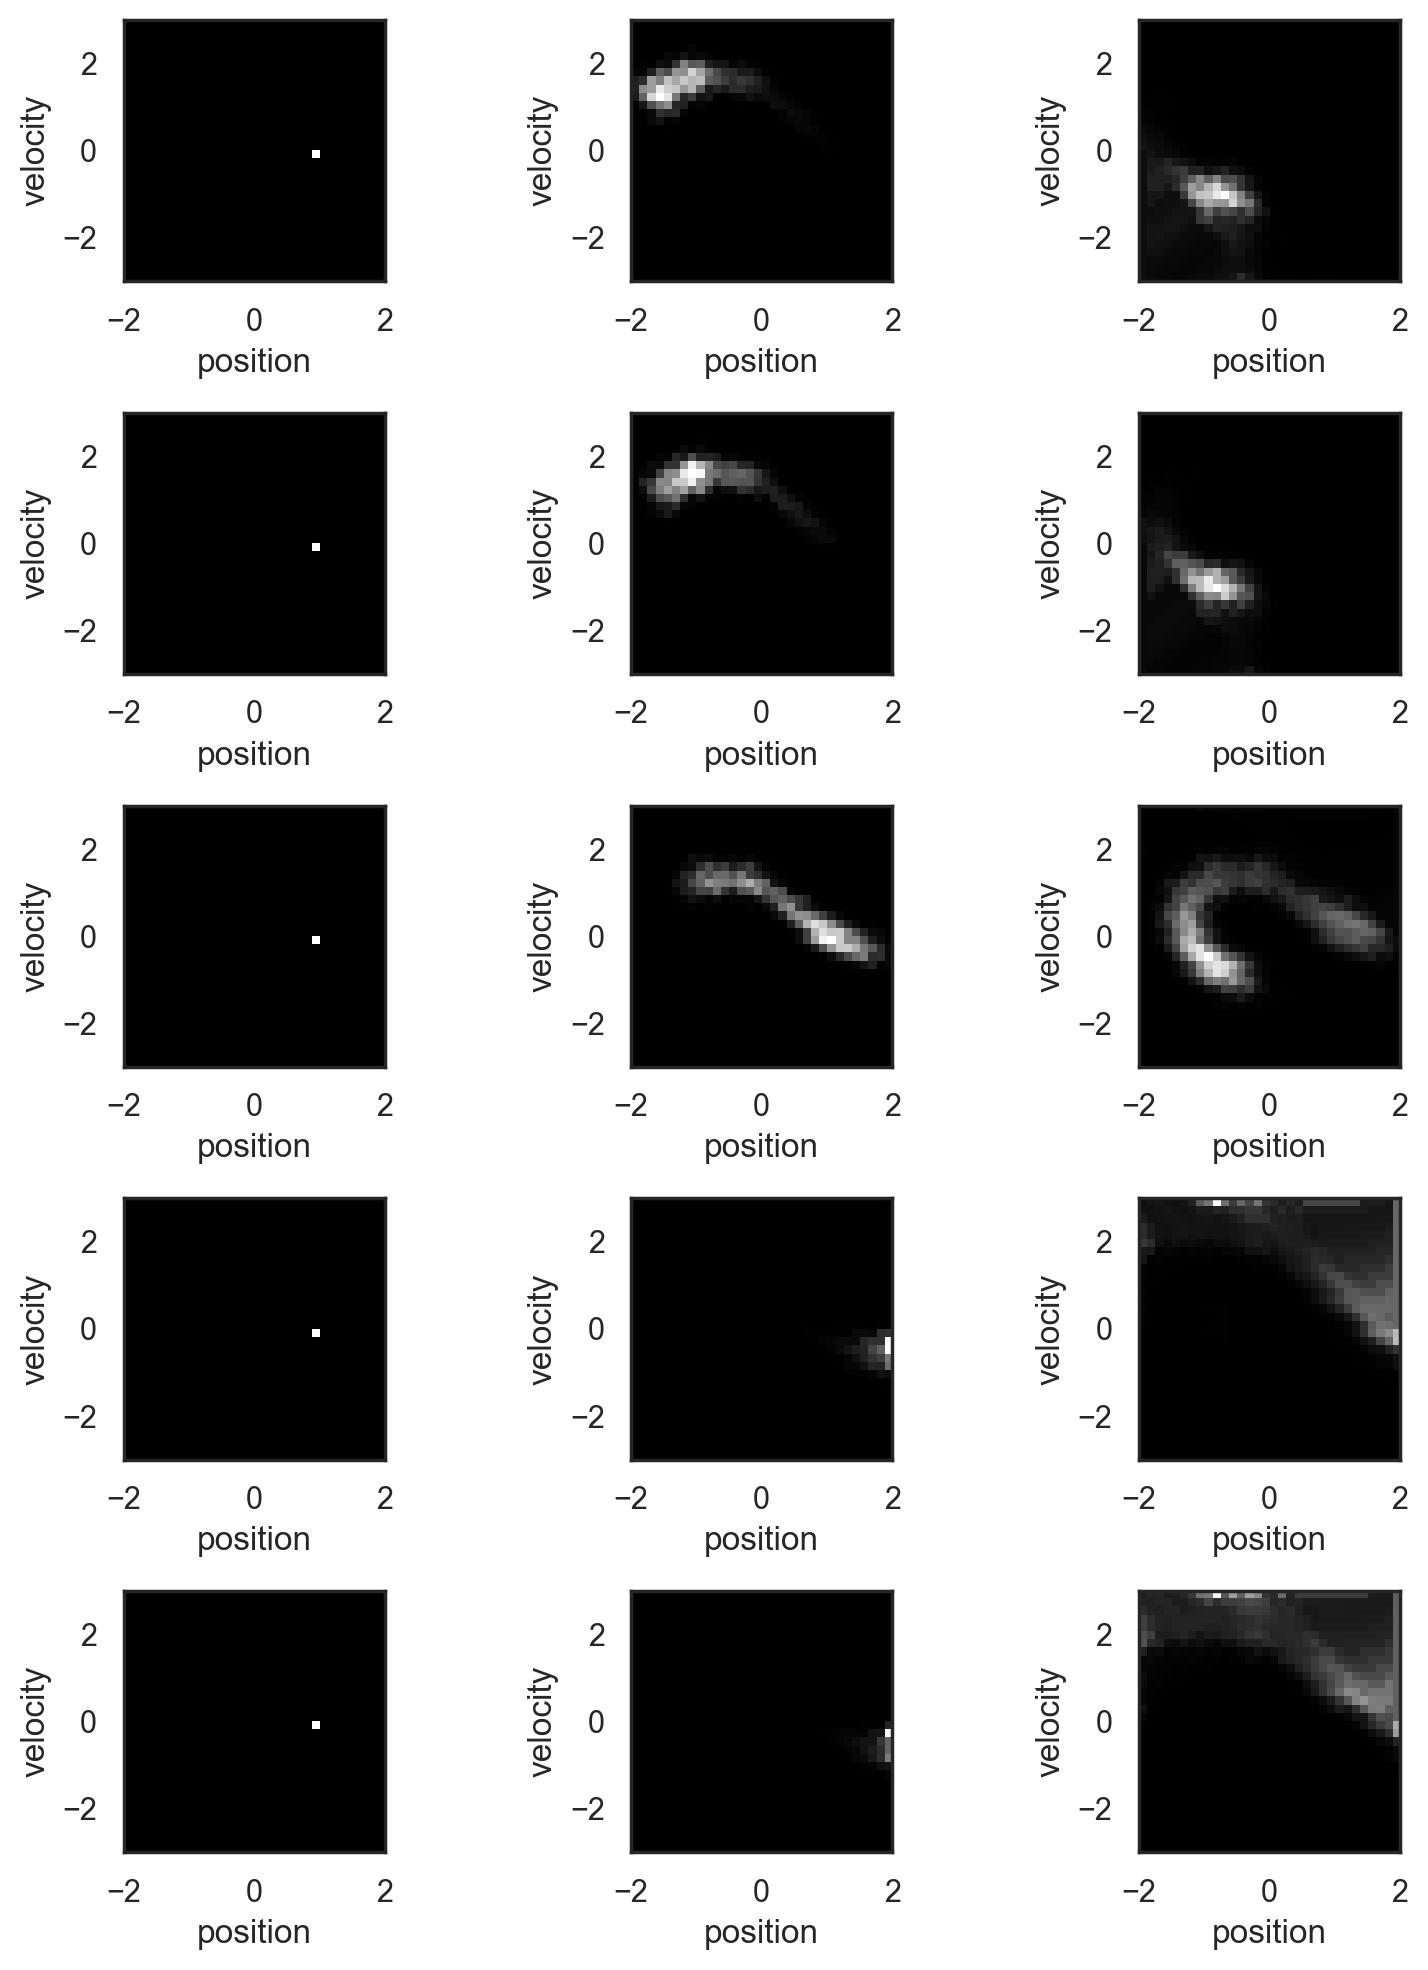

In [25]:
fig, axes = plt.subplots(nrows=len(action_space), ncols=len(n_steps_variations), figsize=(8, 10))

for idx_col, n_steps in enumerate(n_steps_variations):
    for idx_row, action in enumerate(action_space):

        try:
            ax = axes[idx_row, idx_col]
        except IndexError:
            ax = axes[idx_col]
        plot_belief(belief_plot[idx_row, idx_col], 
                    ax=ax, fig=fig, colorbar=False)

plt.tight_layout()

### Testing going backward

In [26]:
starting = np.array([0.0, 0.0])
_, state_idx = tree.query(starting)
state_idx

495

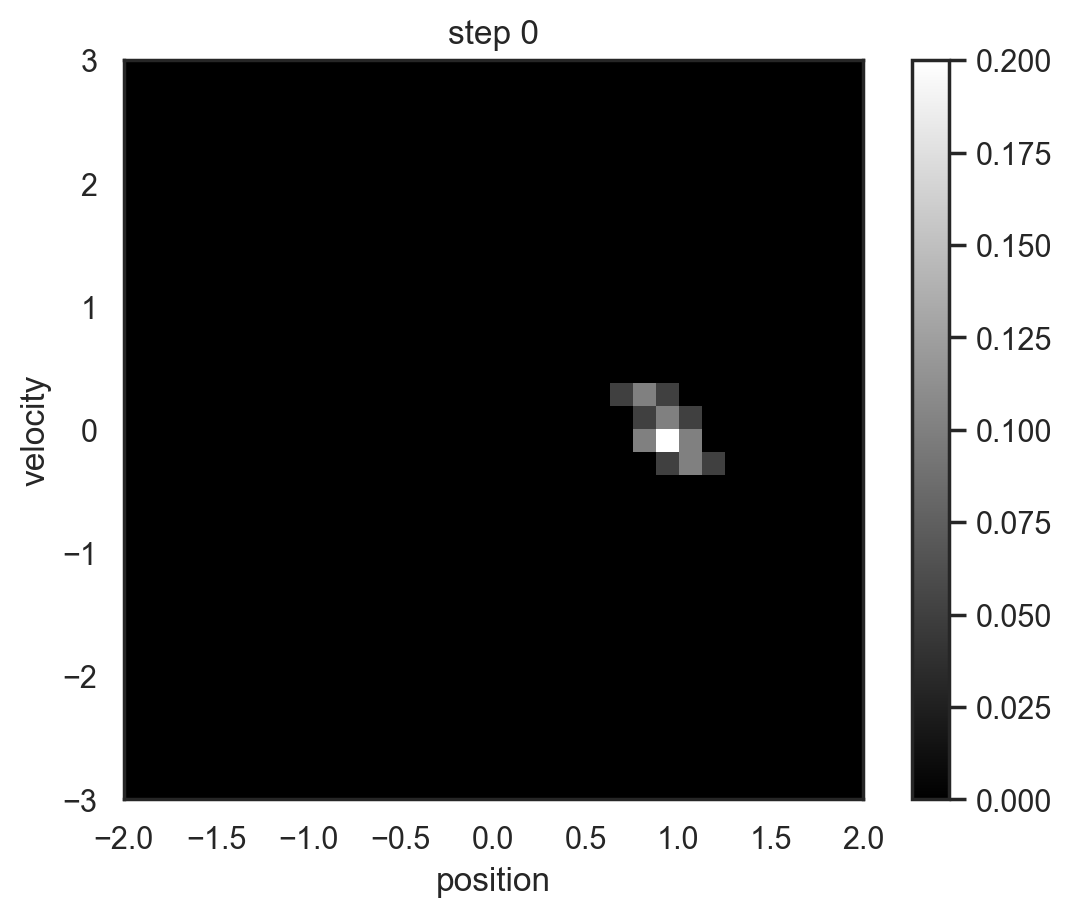

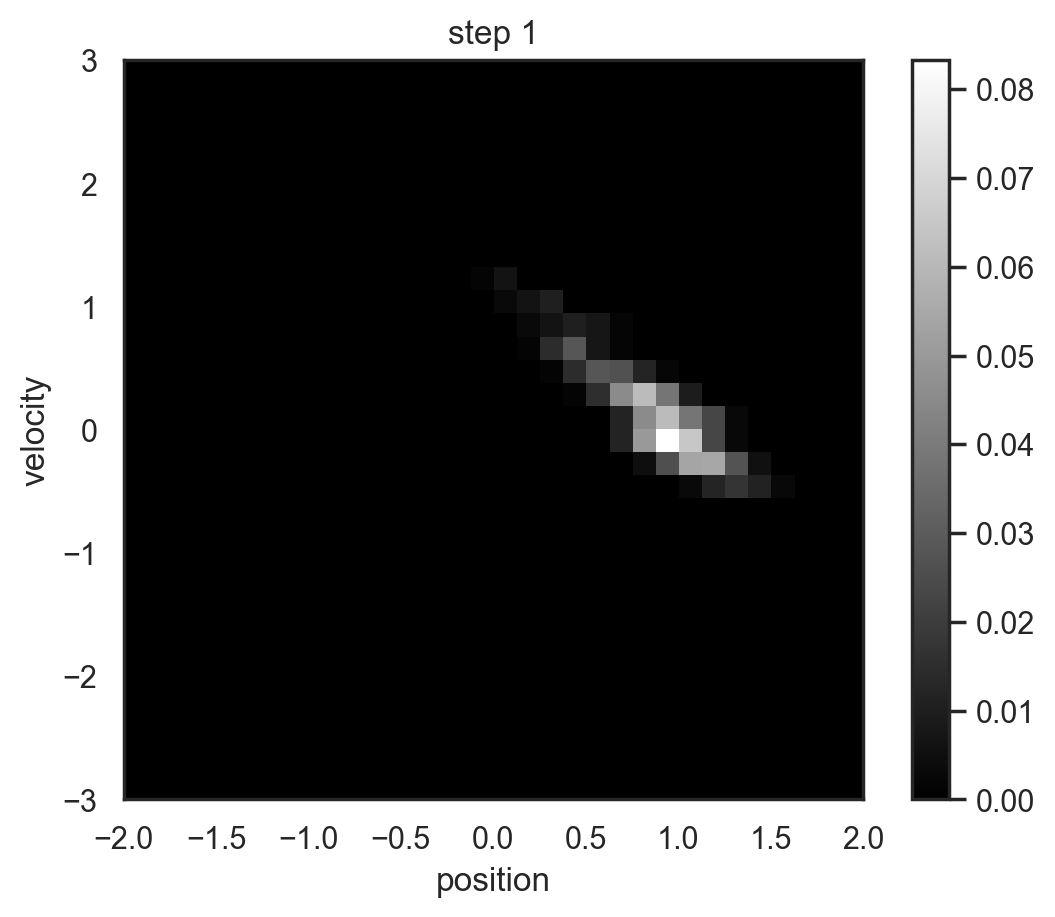

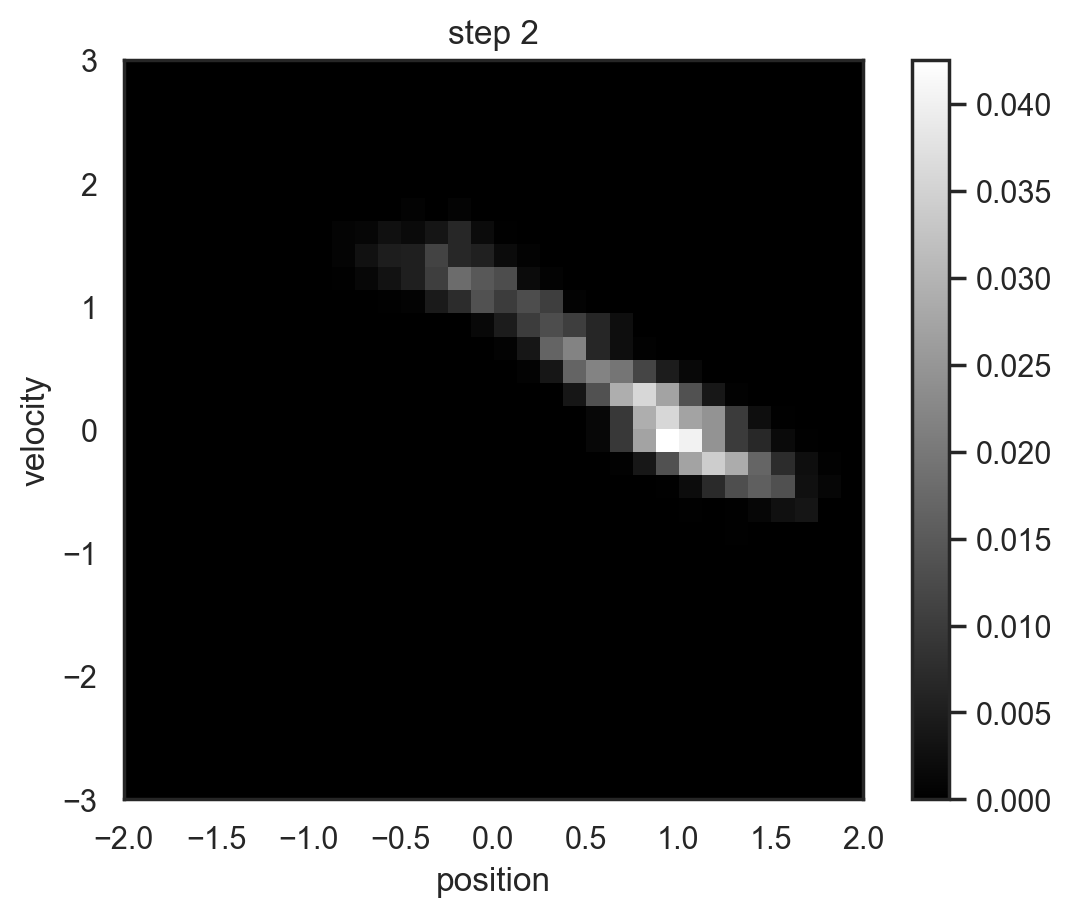

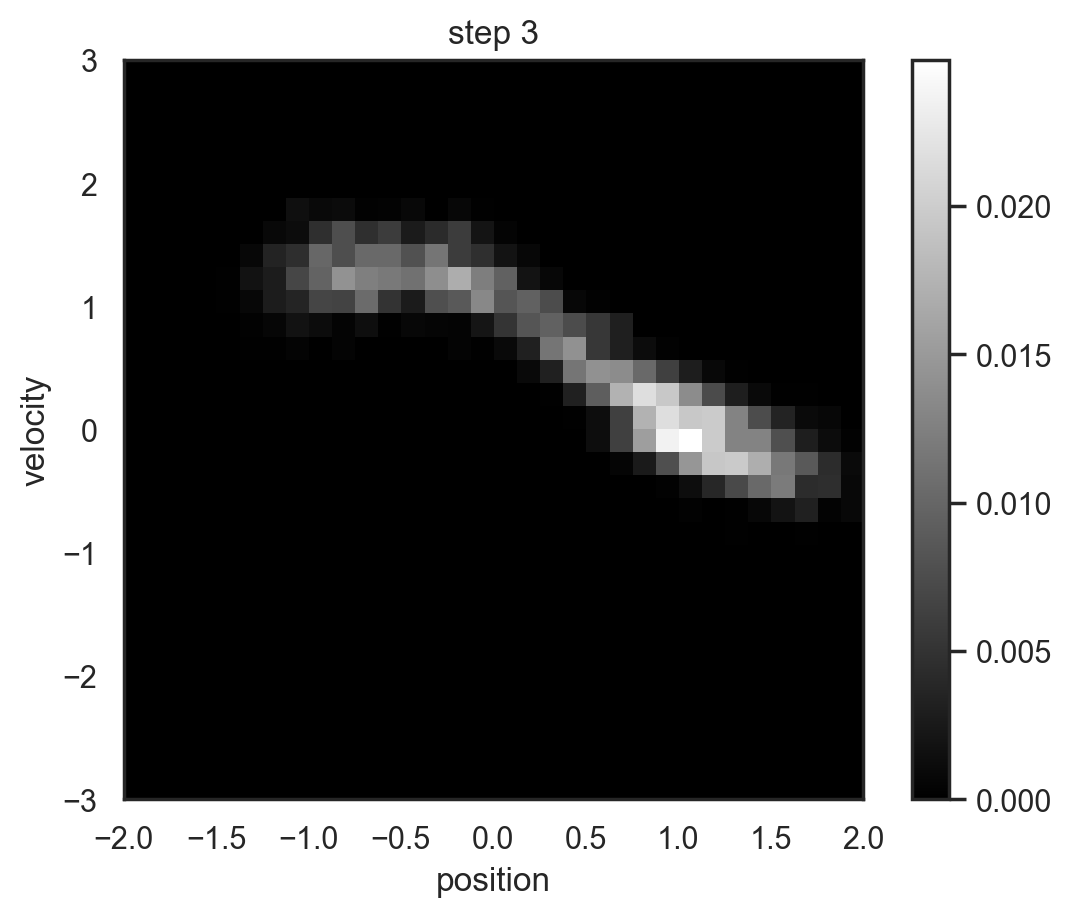

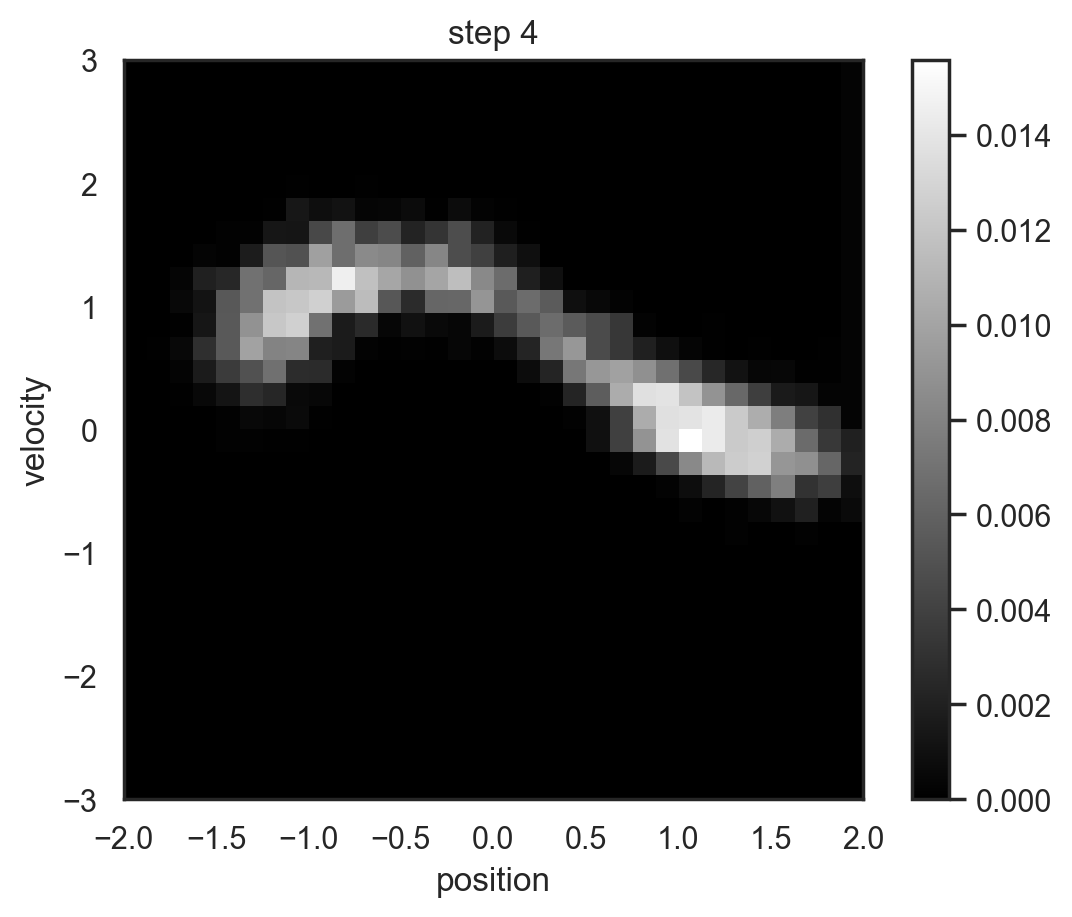

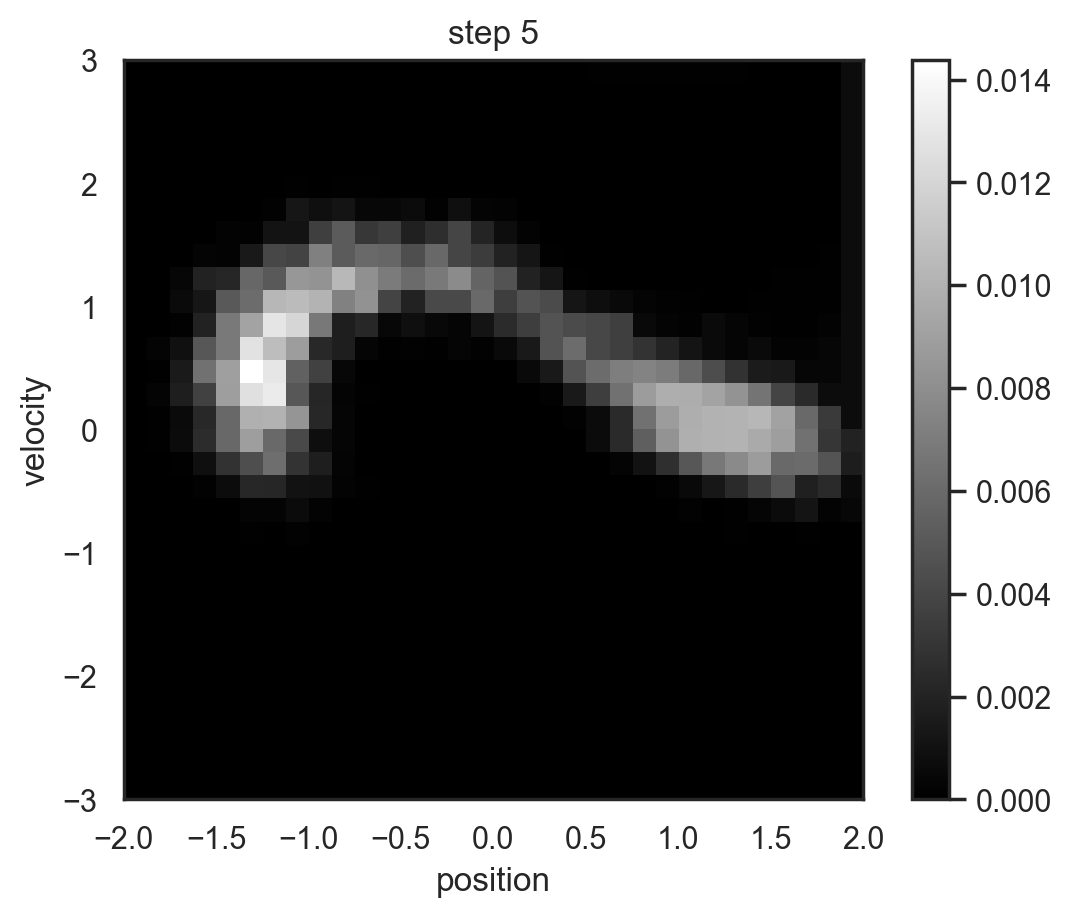

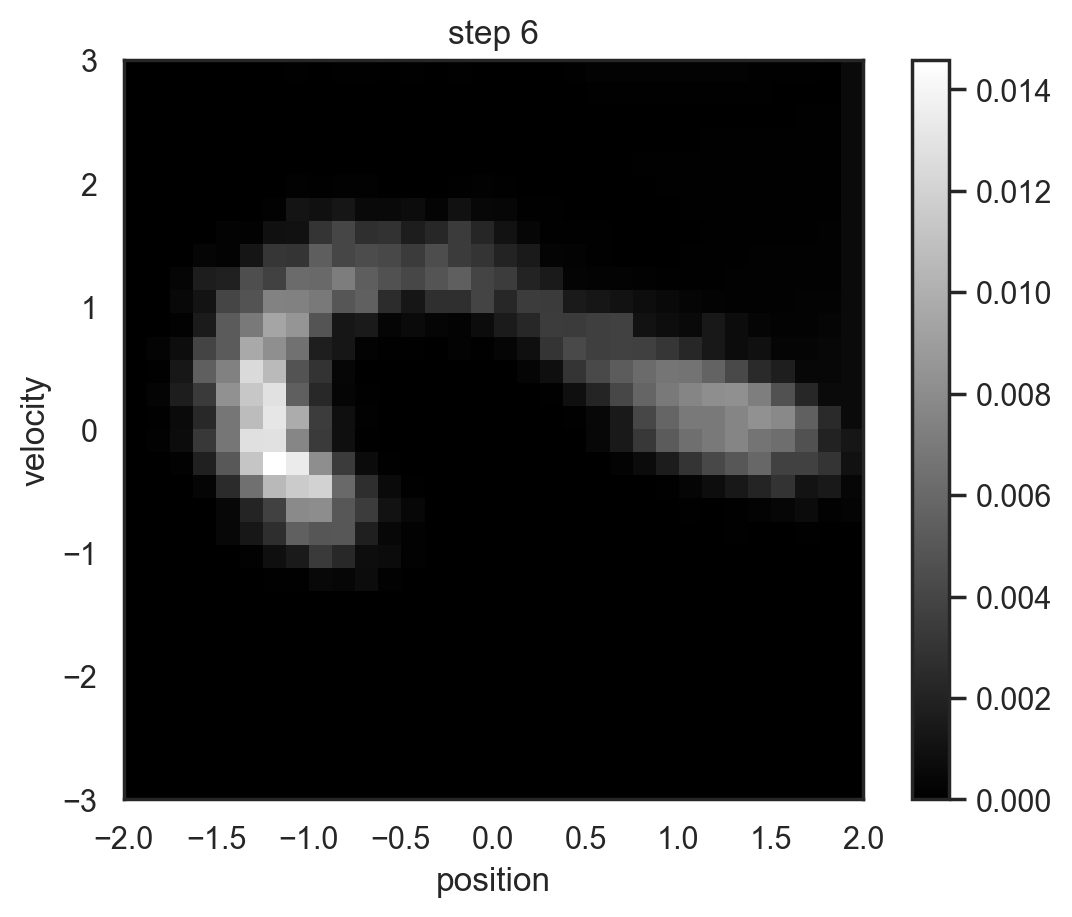

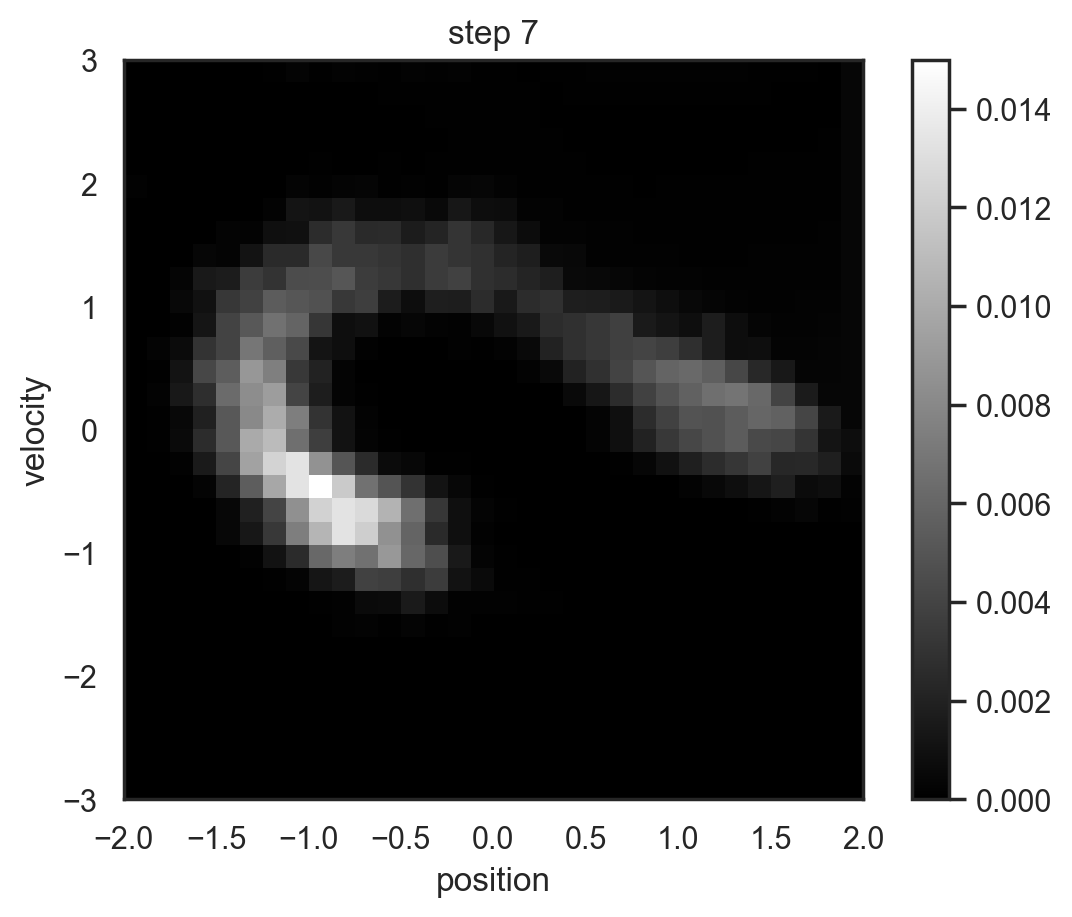

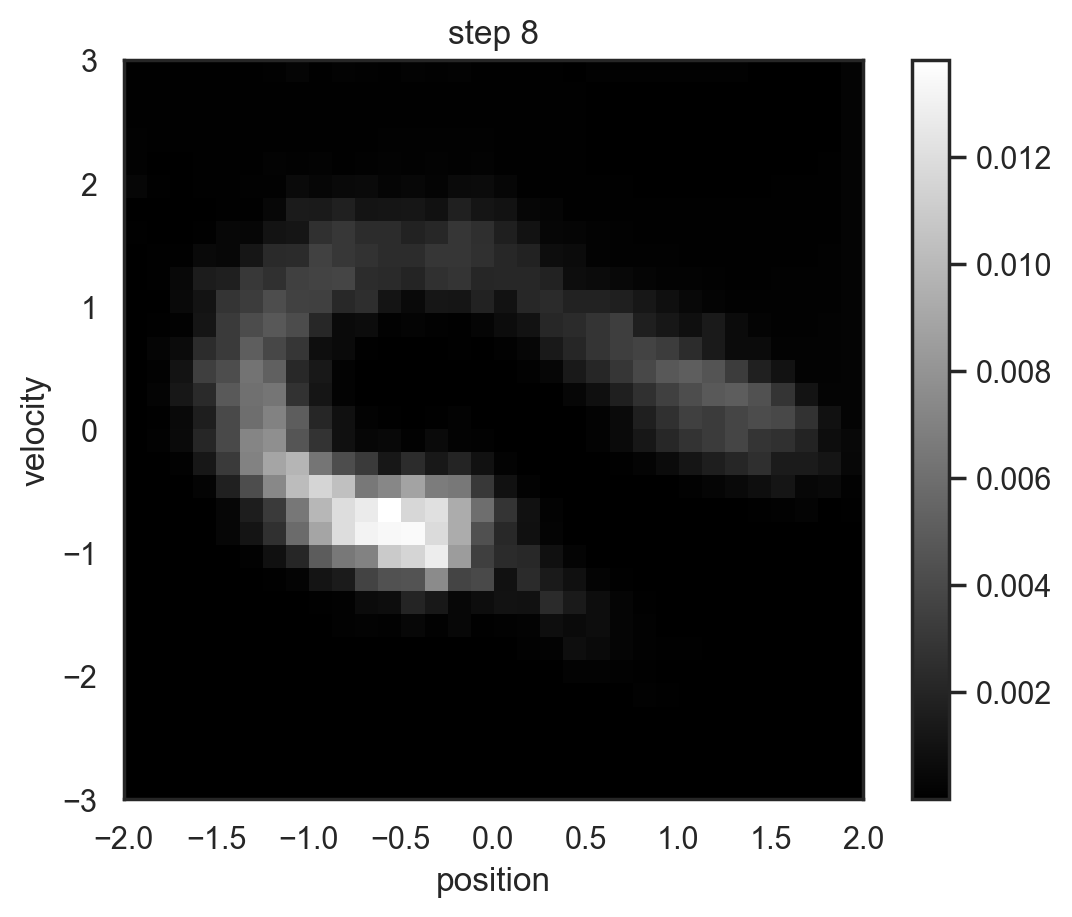

In [27]:
idx_act = 2

starting_motion = np.array([1.0, 0.0])

belief = np.zeros(n_state)
dist, idx = tree.query(starting_motion)
belief[idx] = 1

n_step = n_steps_variations[-1]+1

step = 0
for step in range(n_step):

    belief = np.dot(p_backward[idx_act], belief)
    # print(belief.sum())

    plot_belief(belief)
    plt.title(f"step {step}")
    step += 1

### Testing going forward

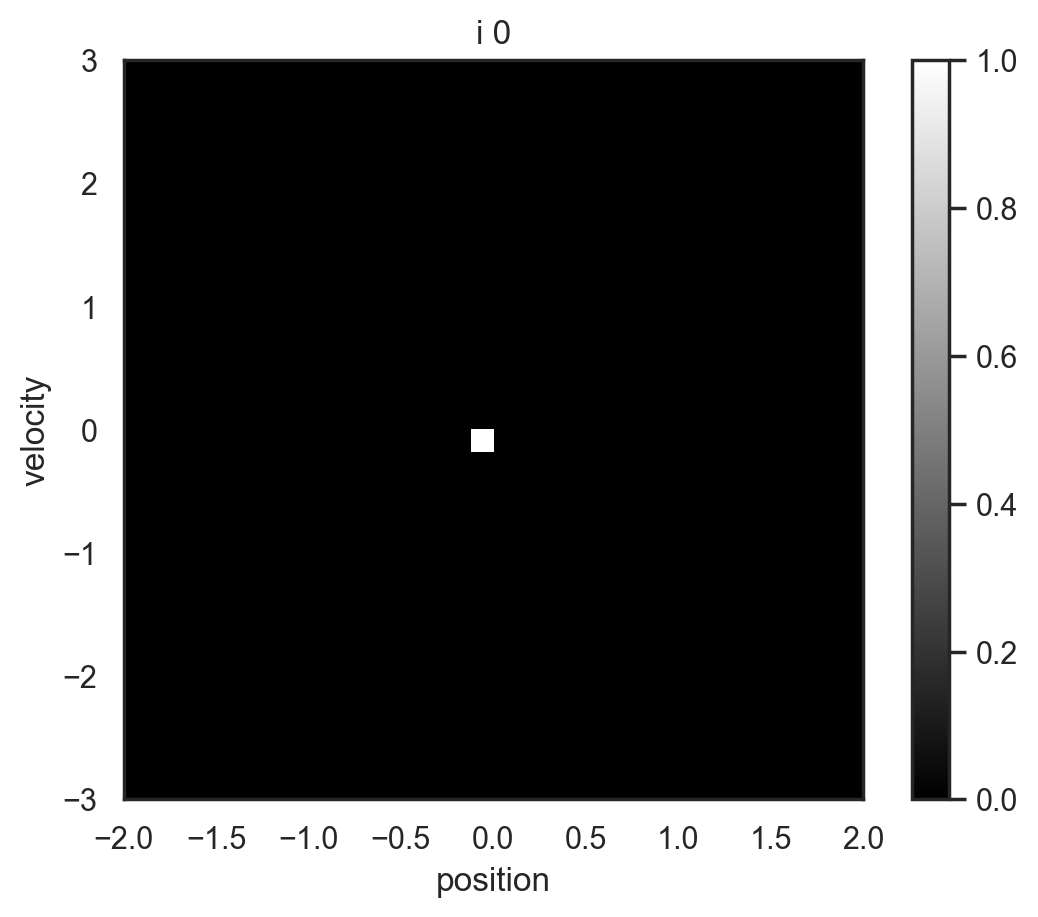

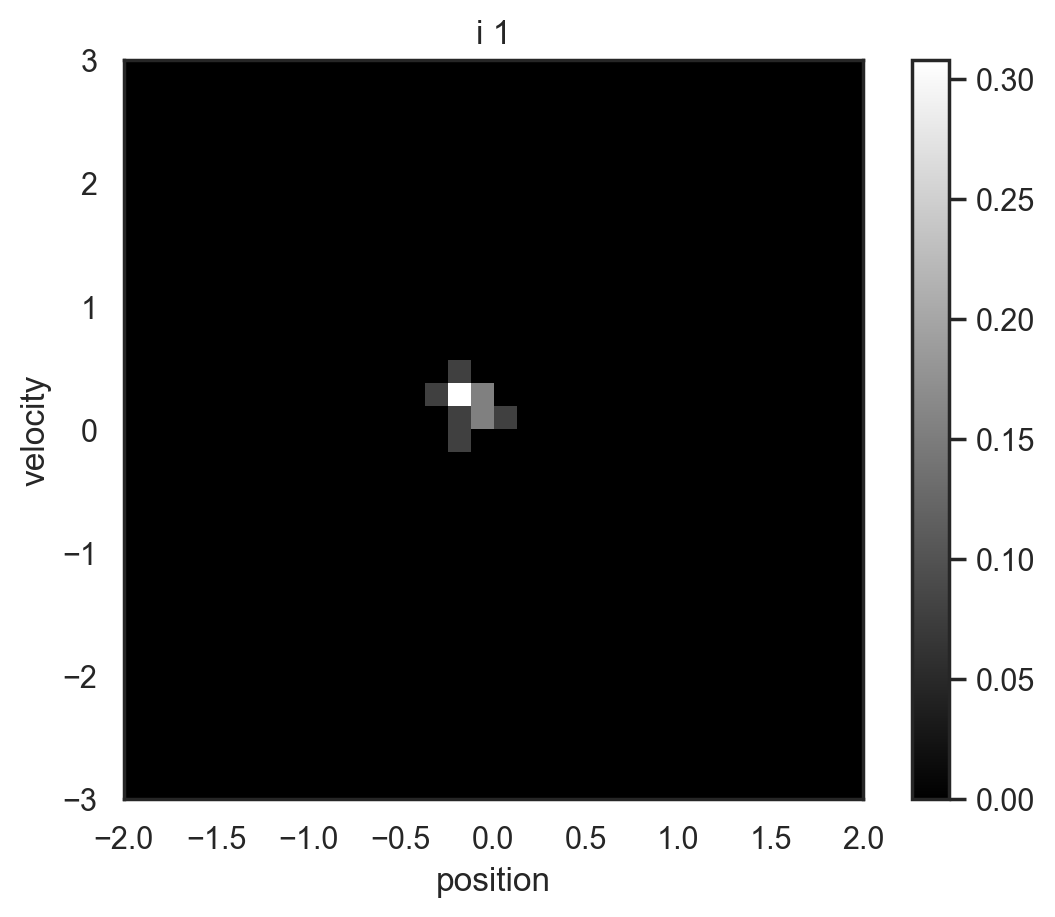

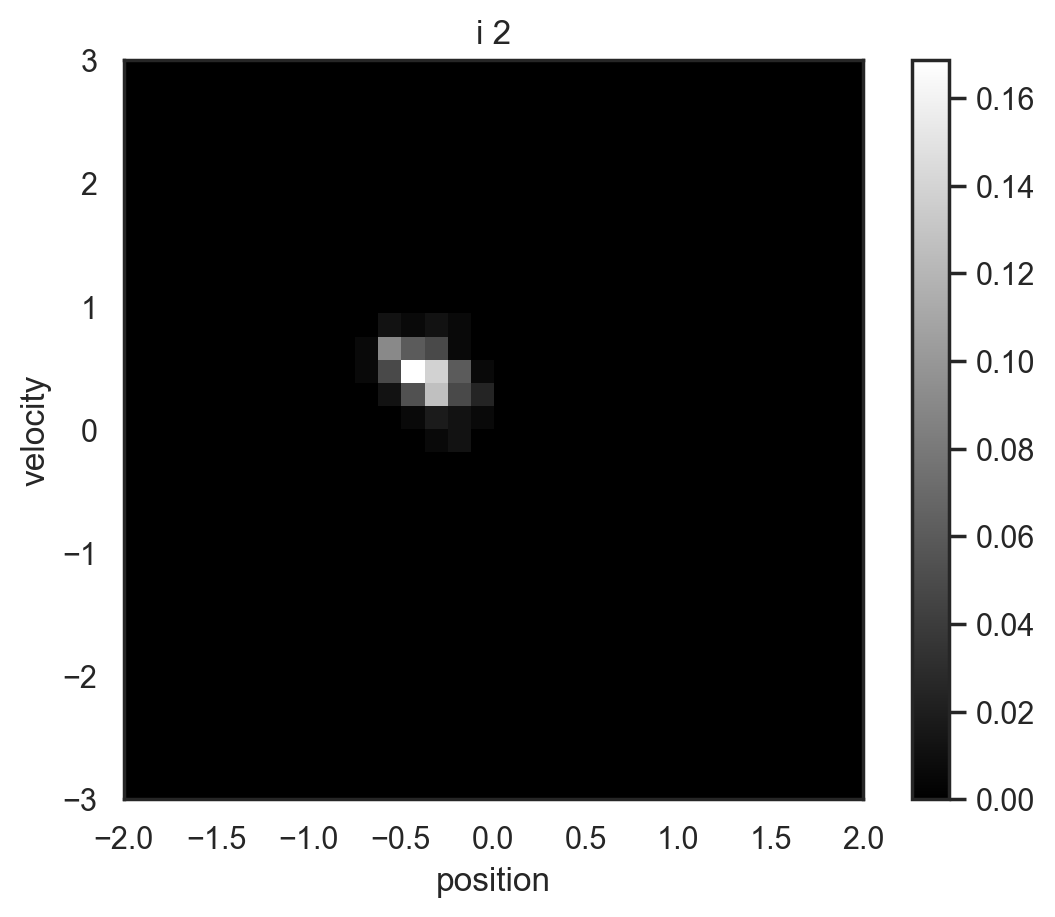

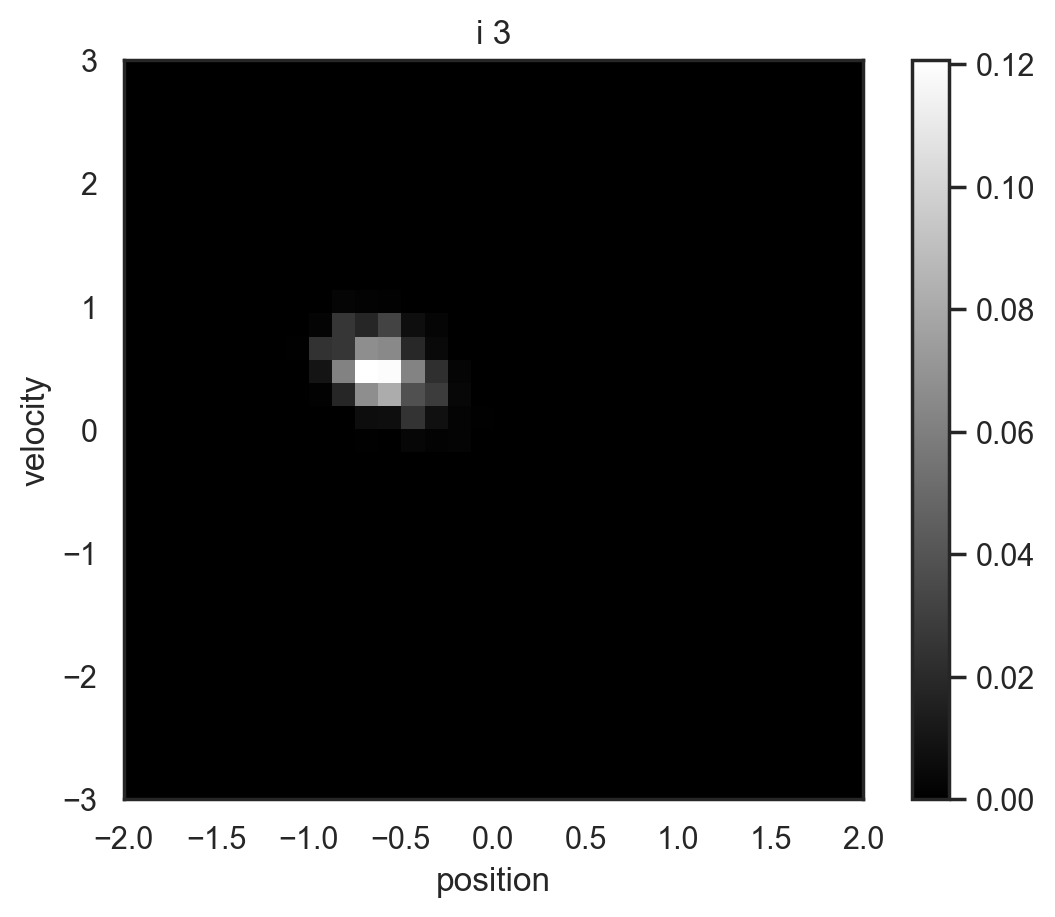

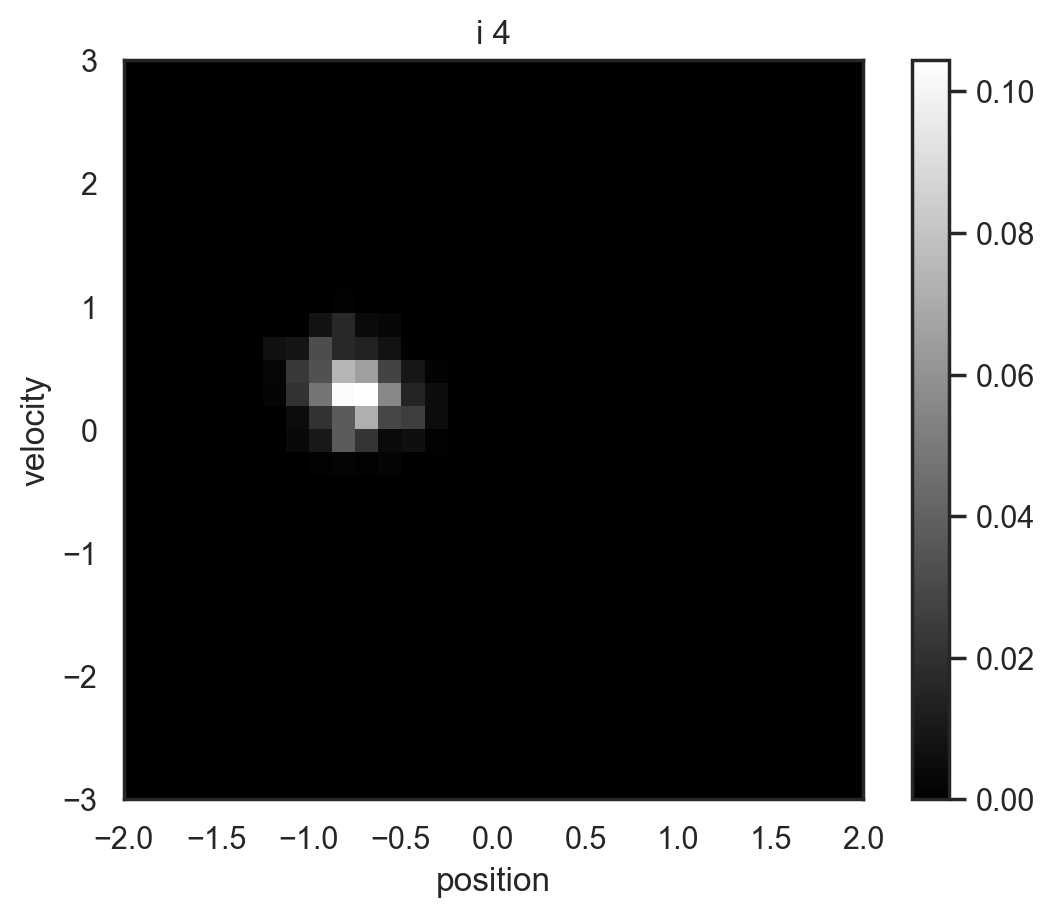

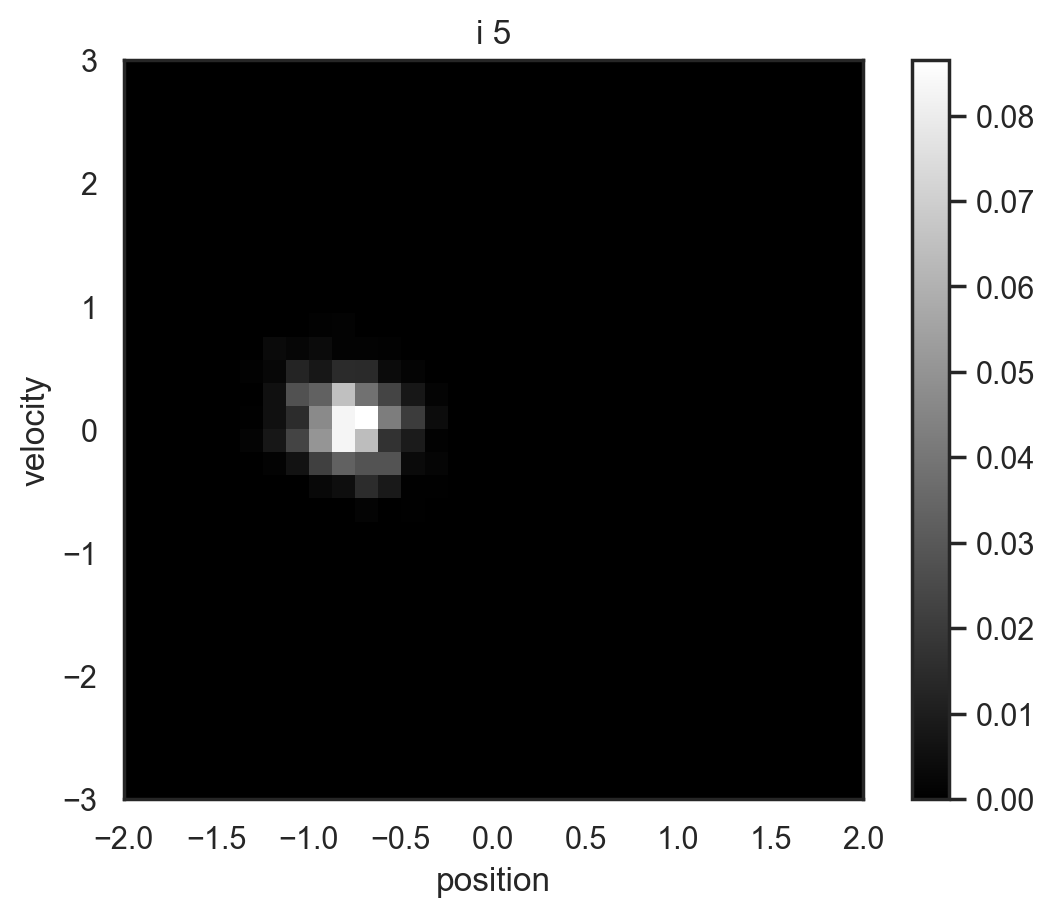

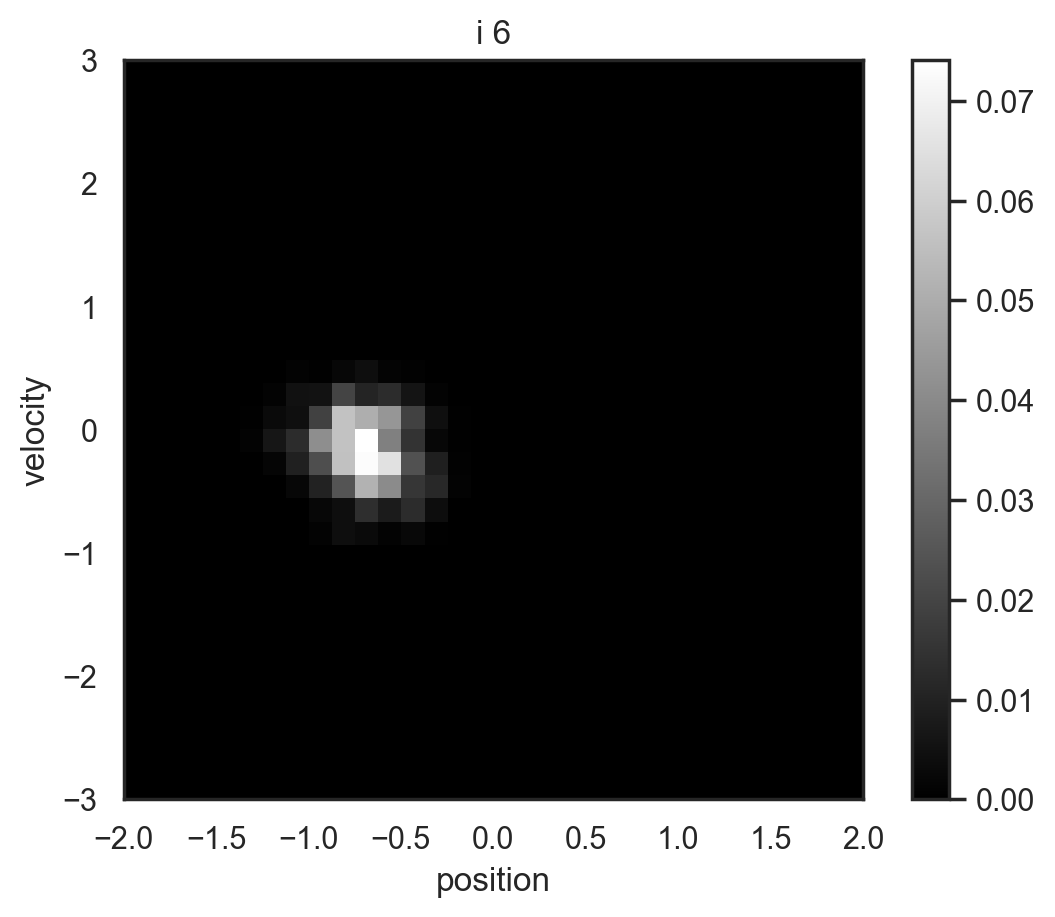

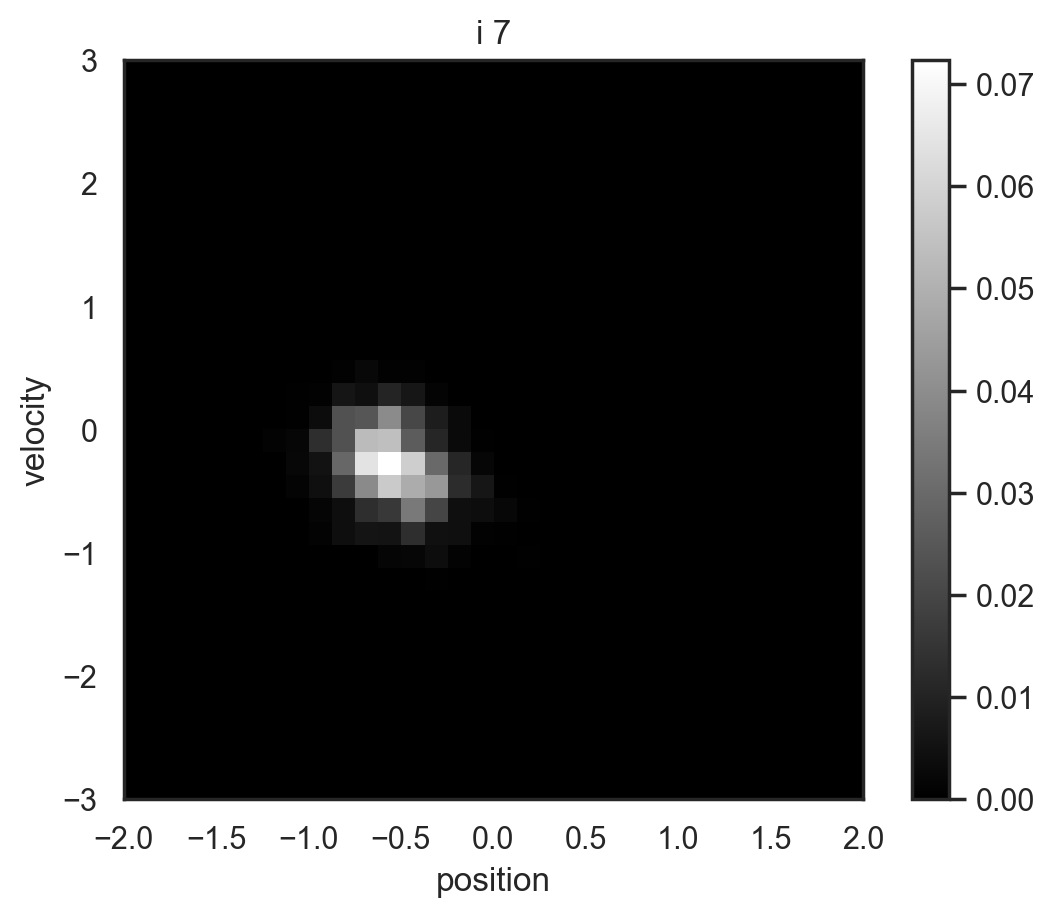

In [28]:
starting = np.array([0.0, 0.0])
_, starting_idx = tree.query(starting)

belief = np.zeros(n_state)
belief[starting_idx] = 1. # Encode the goal

idx_act = 2

i = 0
for t in range(n_step-1):
    
    plot_belief(belief)
    plt.title(f"i {i}")
    
    belief = np.dot(p_forward[idx_act], belief)  # np.dot(belief, p_backward[idx_act])
    belief /= belief.sum()
    i += 1

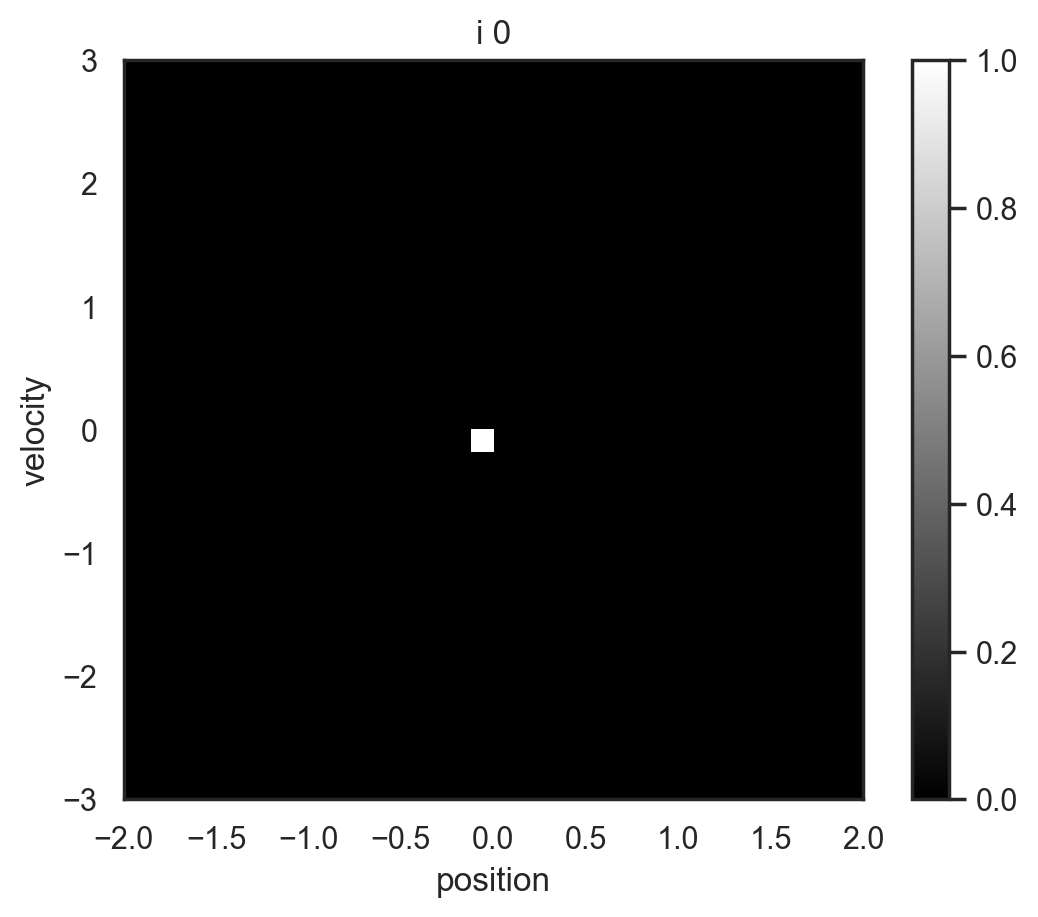

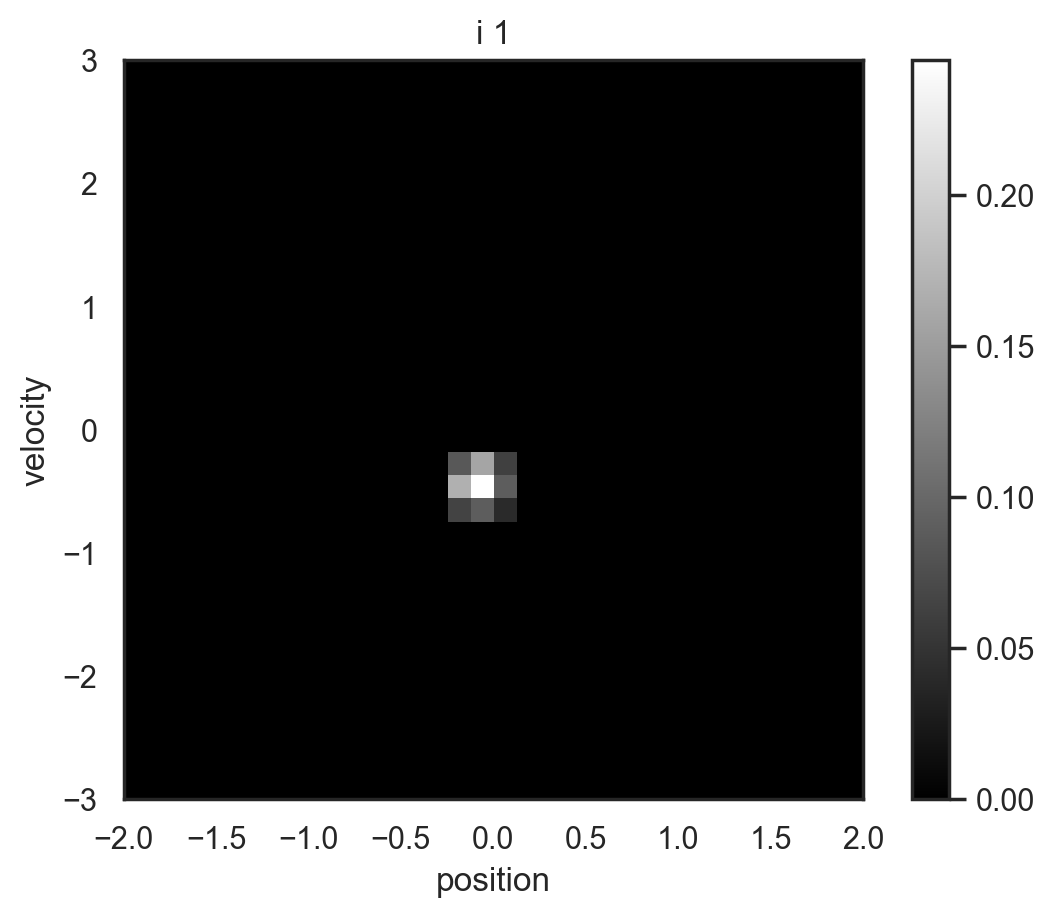

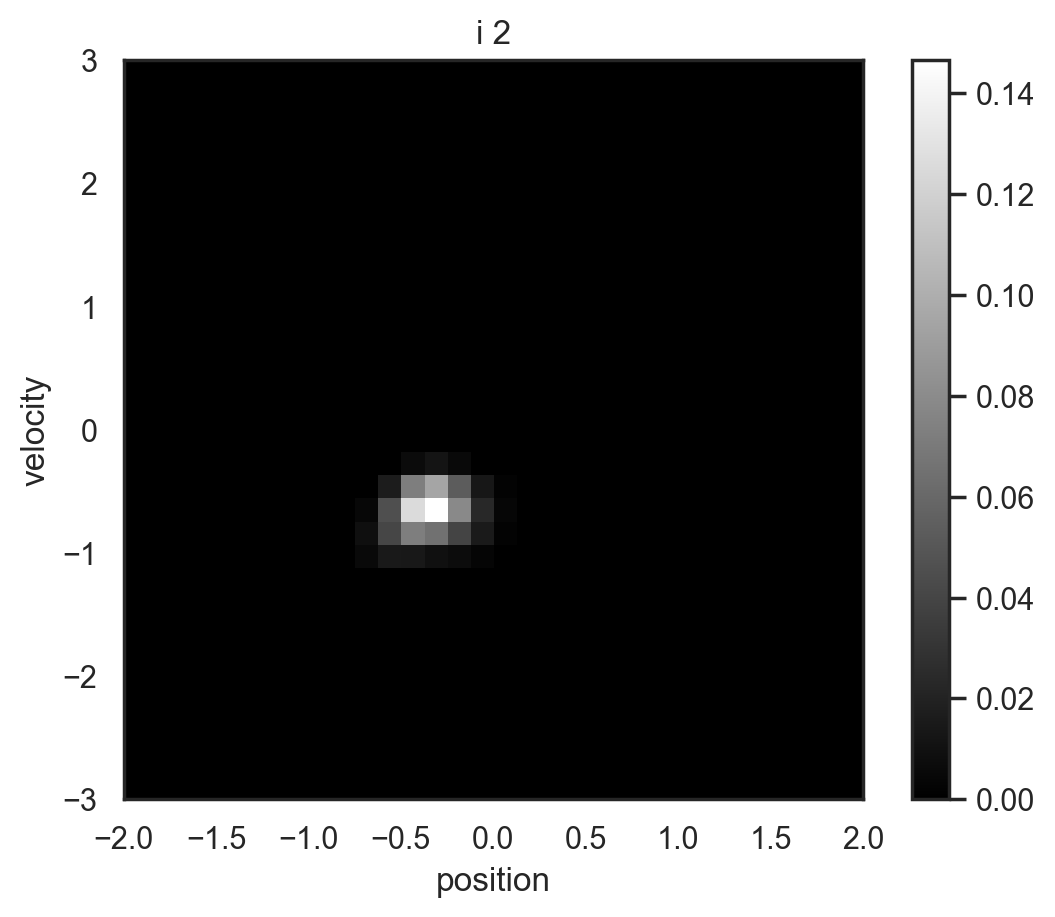

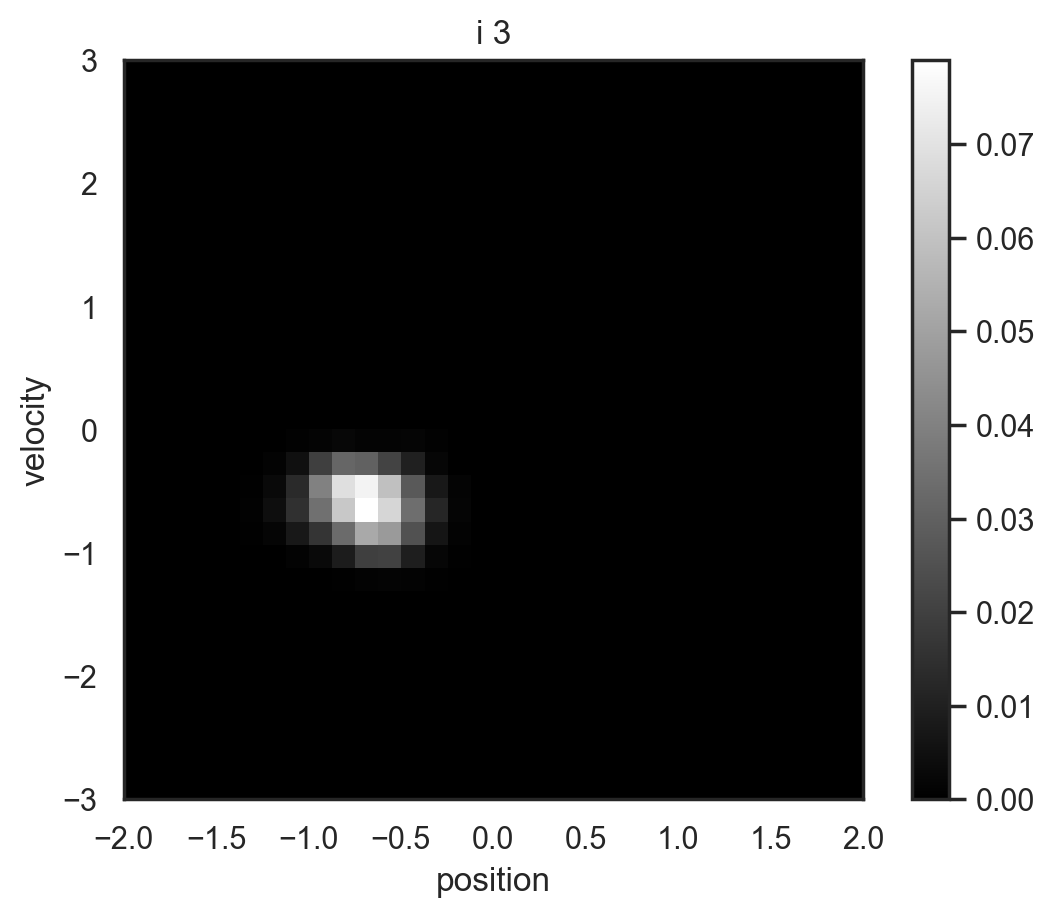

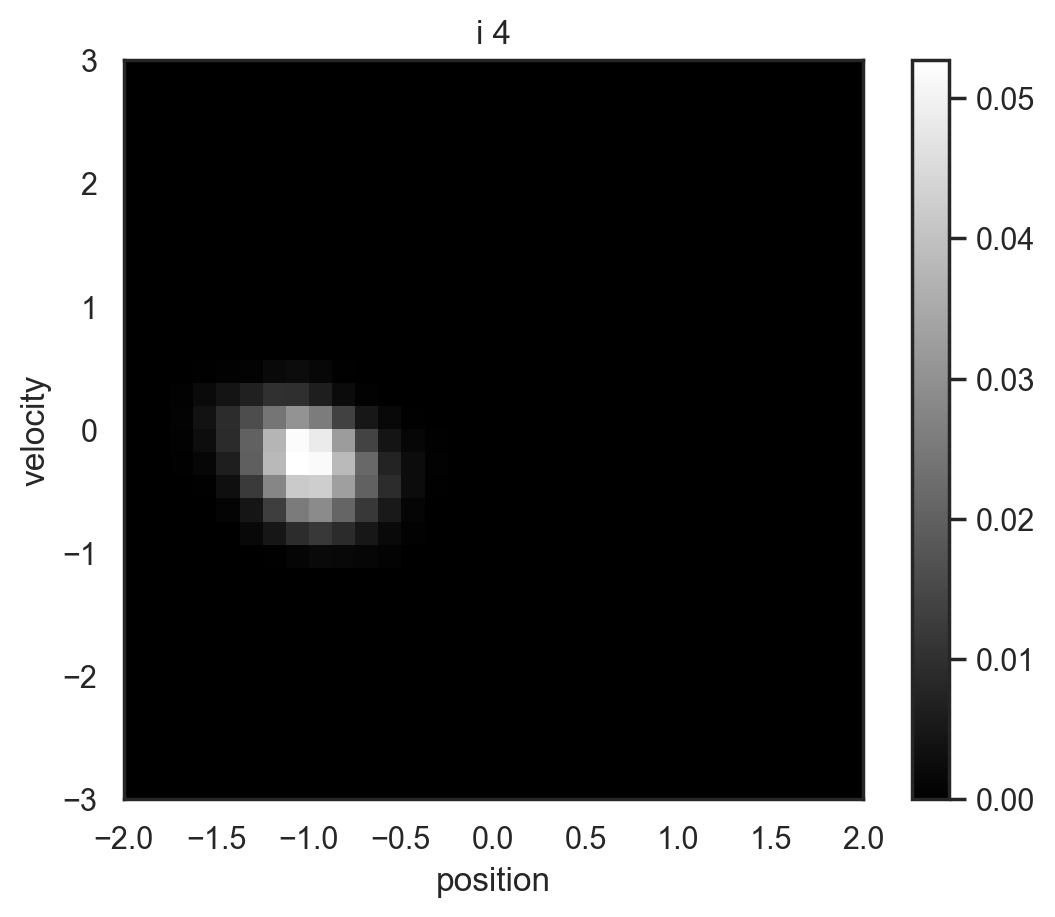

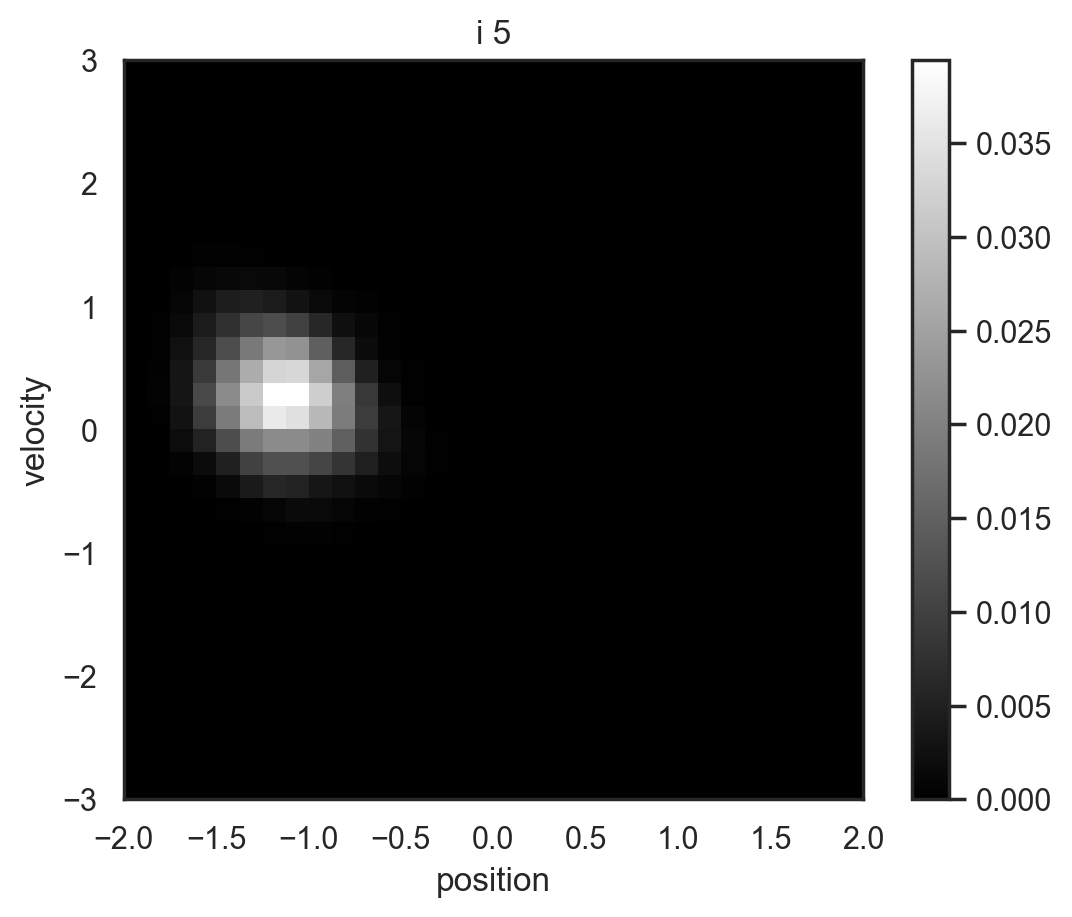

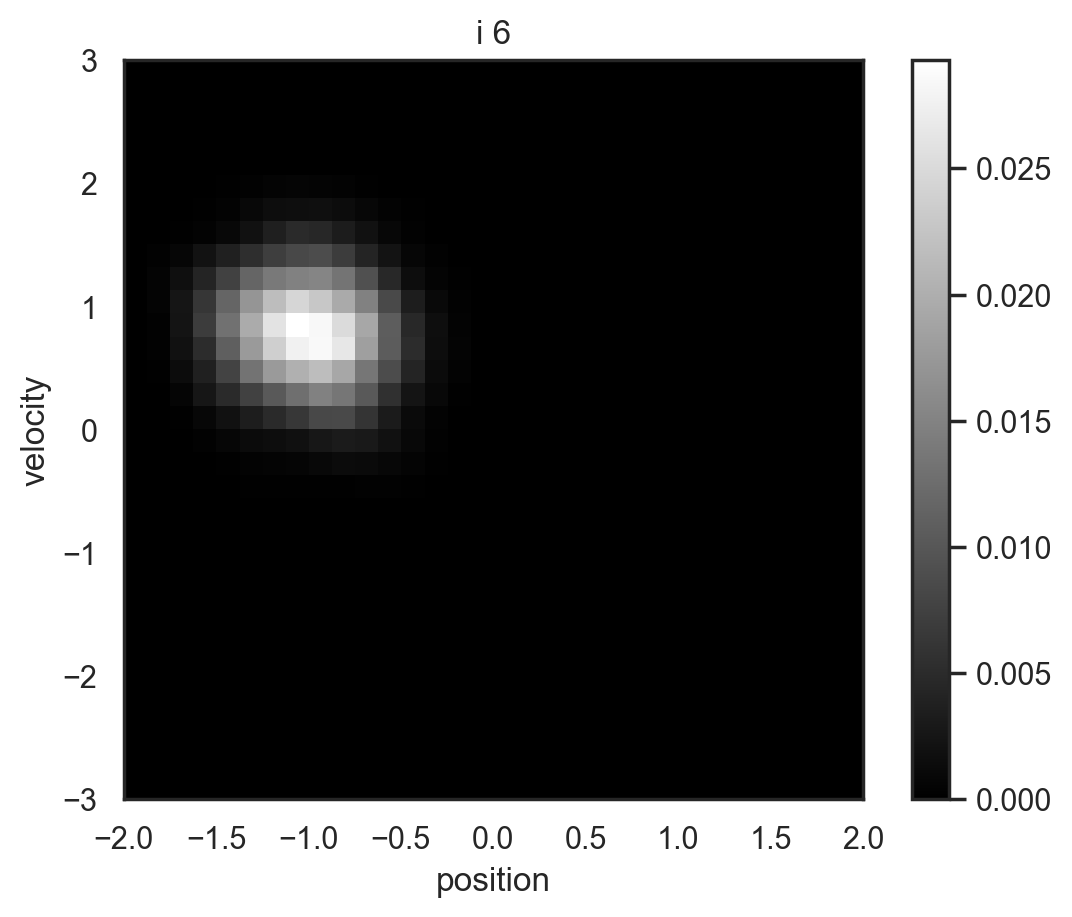

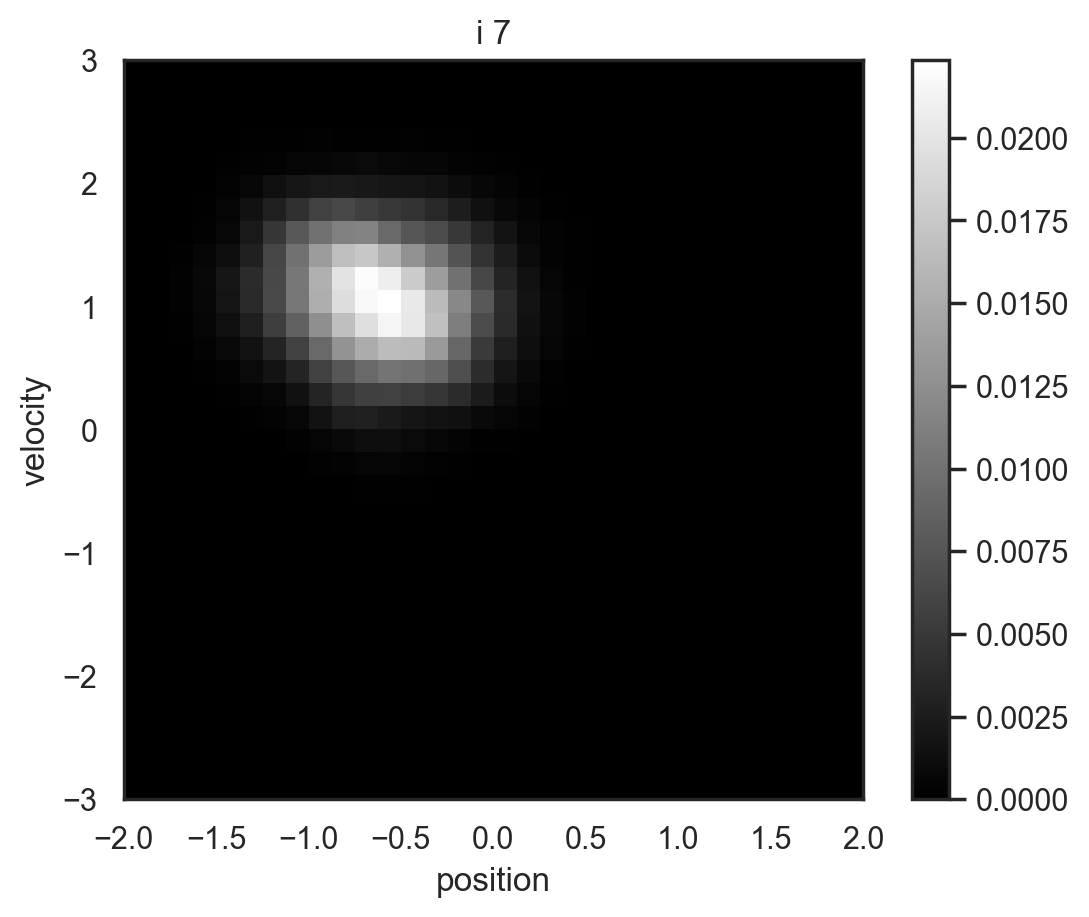

In [29]:
belief = np.zeros(n_state)
belief[starting_idx] = 1. # Encode the starting

idx_act = 2

i = 0
for t in range(n_step-1):
    
    plot_belief(belief)
    plt.title(f"i {i}")
    
    belief = np.dot(belief, p_backward[idx_act])
    belief /= belief.sum()
    i += 1

## Simulation

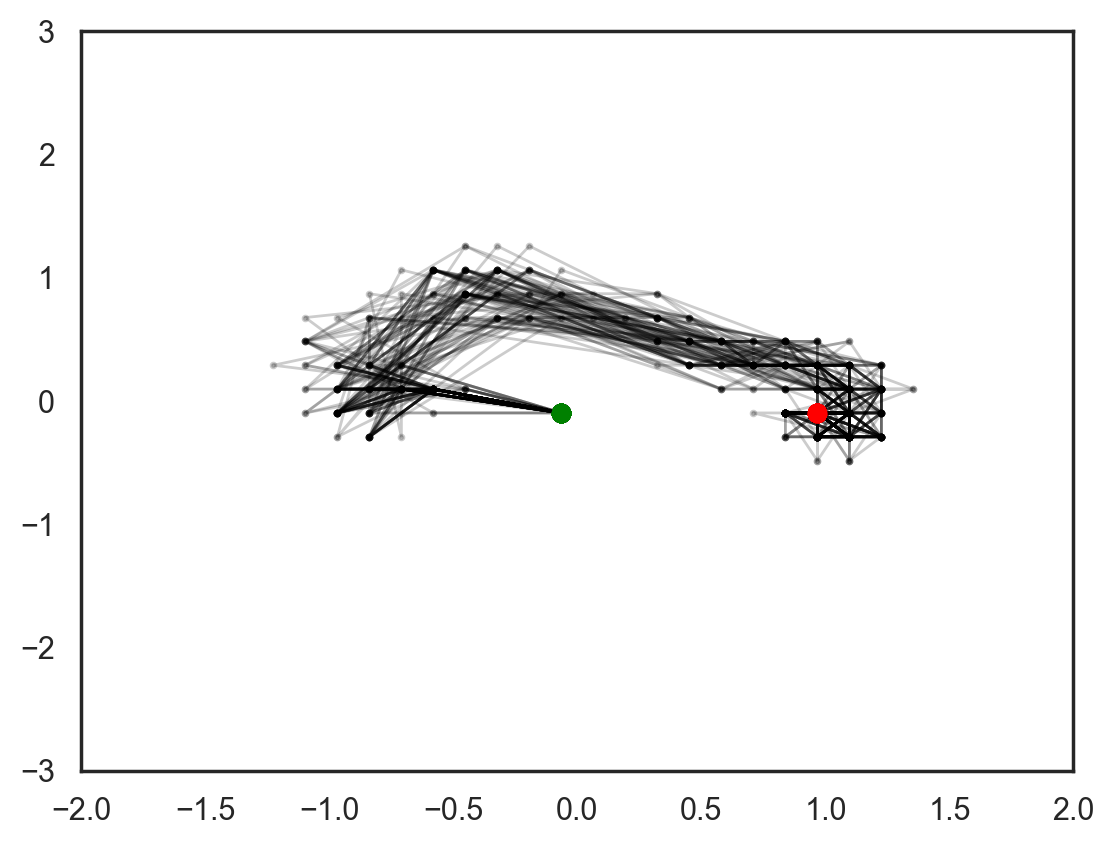

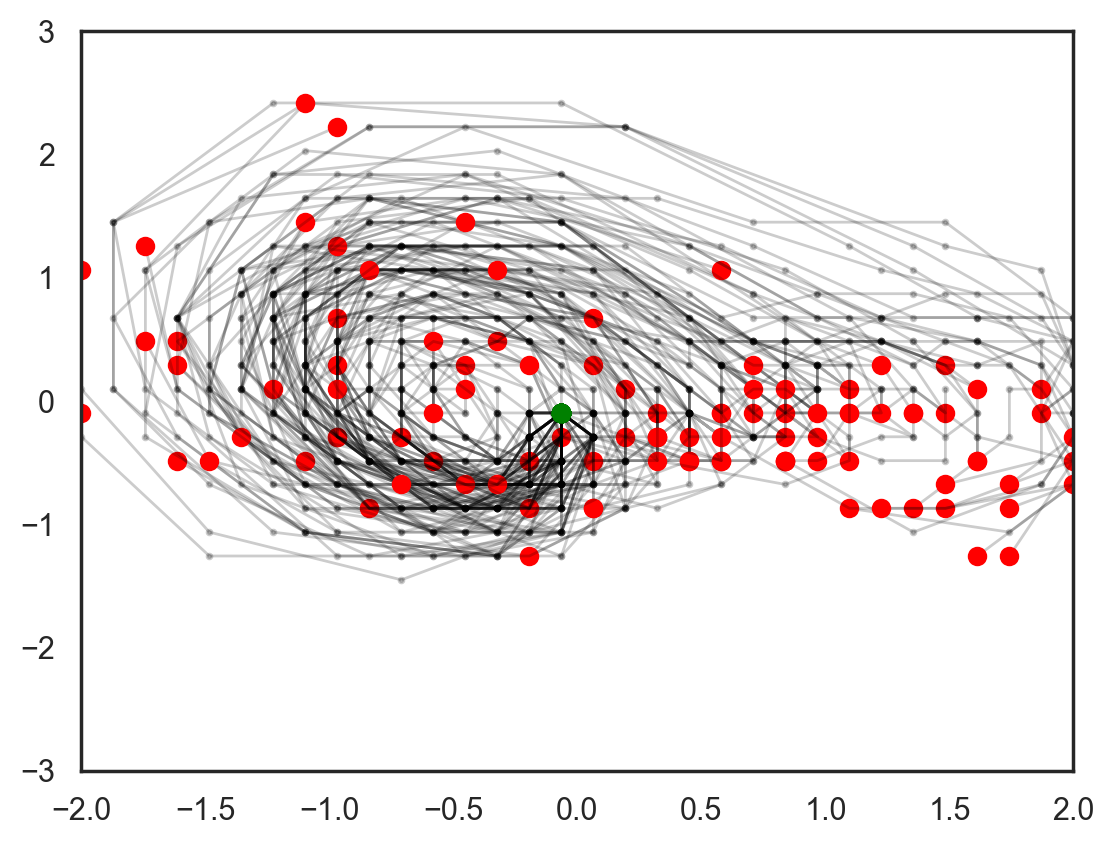

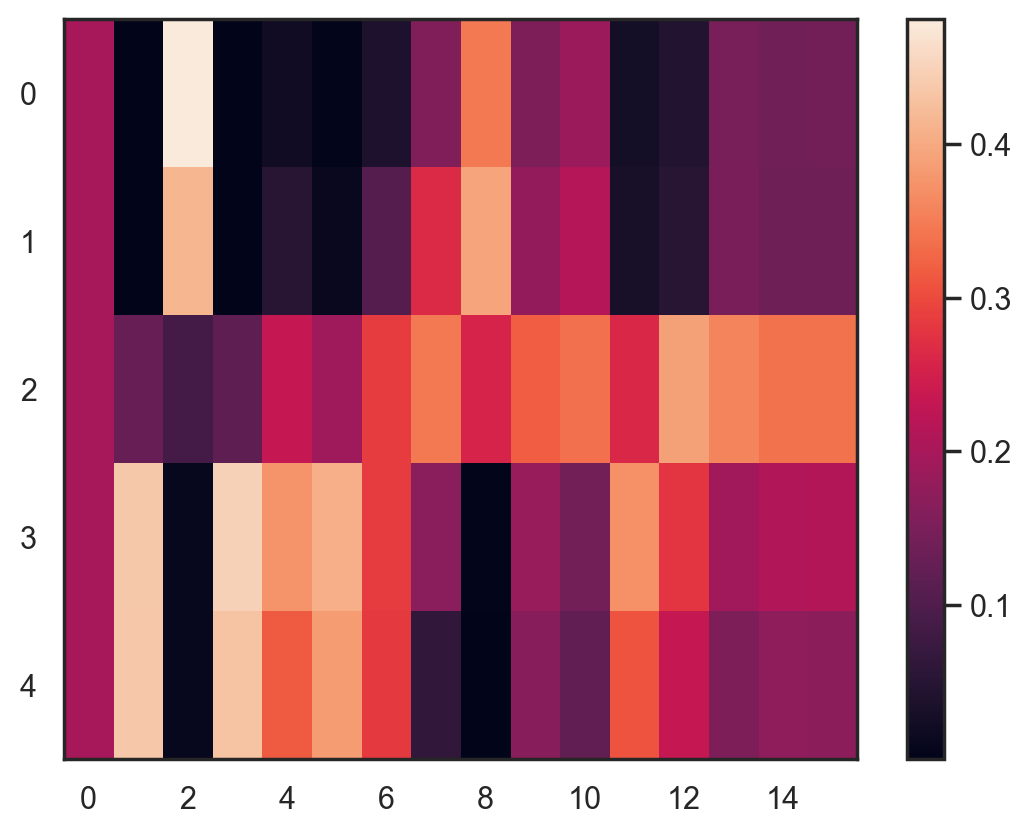

In [30]:
def normalize(q):
    q_sum = q.sum()
    if q_sum > 0:
        q /= q_sum
    return q

def safe_log(q):
    return np.log(np.maximum(q, 1e-16))

n_step = 16  # 16 or 32
n_epoch = 20

coords = np.dstack(np.meshgrid(position_space, velocity_space)).reshape(-1, 2)
n_state = len(position_space) * len(velocity_space)
n_action = len(action_space)

tree = scipy.spatial.KDTree(coords)

goal = np.array([1.0, 0.0]) # goal = np.array([1.0, -1.0]) # goal = np.array([1.0, 0.0])
_, goal_idx = tree.query(goal)

starting = np.array([0.0, 0.0])
_, starting_idx = tree.query(starting)

d = np.ones(n_action) / n_action
    
alpha = np.ones((n_step, n_state)) # / n_state  # State dist sufficient statistics
beta = np.ones((n_step, n_action)) # / n_action # Action dist sufficient statistics

for step in range(n_step):
    alpha[step] /= alpha[step].sum()
    beta[step] /= beta[step].sum()

alpha[-1, :] = 0.
alpha[-1, goal_idx] = 1.    # Encode the goal
            
alpha[0, :] = 0.
alpha[0, starting_idx] = 1. # Encode the knowledge of current state
    
T = n_step - 1

hist_beta = np.zeros((n_epoch, n_step, n_action))
hist_alpha = np.zeros((n_epoch, n_step, n_state))
        
for epoch in tqdm(range(n_epoch), leave=False, desc="Epoch"):
    
    new_alpha = np.ones((n_step, n_state))
    new_beta = np.ones((n_step, n_action))
    
    for t in reversed(range(1, T+1)):
        
        if t < T:
            backward_msg = np.dot(beta[t+1], safe_log(np.dot(p_backward, alpha[t+1])))
            forward_msg = np.dot(beta[t], safe_log(np.dot(alpha[t], p_backward)))
            new_alpha[t] = normalize(np.exp(backward_msg + forward_msg))
            
        q_action = np.zeros(n_action)
        for i in range(n_action):
            q_action[i] = np.dot(alpha[t-1].T, safe_log(np.dot(p_backward[i], alpha[t])))
        new_beta[t] = normalize(np.exp(q_action))
    
    for t in range(1, T+1):
        if t < T:
            alpha[t] += np.clip(new_alpha[t] - alpha[t], -0.1, 0.1)
        alpha[t] = normalize(alpha[t])
    
        beta[t] += np.clip(new_beta[t] - beta[t], -0.1, 0.1)
        beta[t] = normalize(beta[t])
    
    hist_beta[epoch] = beta
    hist_alpha[epoch] = alpha
    
    
# -------------------------------------------------- #
# -------------------------------------------------- #
    
n_sample = 100

sample_trajectories = np.zeros((n_sample, n_step, 2))

for i in range(n_sample):
    for t in range(0, n_step):
        state_idx = np.random.choice(np.arange(n_state), p=alpha[t])
        sample_trajectories[i, t] = coords[state_idx]
    
    
# ------------------------------------------------- #

fig, ax = plt.subplots()
for i in range(n_sample):
    traj = sample_trajectories[i]
    ax.scatter(x=traj[:-1, 0], y=traj[:-1, 1], s=3, color="black", alpha=0.2)
    ax.plot(traj[:, 0], traj[:, 1], color="black", alpha=0.2, lw=1)
    x, y = traj[-1, :]
    ax.scatter(x=x, y=y, color="red", zorder=2)
    
    x, y = traj[0, :]
    ax.scatter(x=x, y=y, color="green", zorder=2)
    
ax.set_xlim(-2, 2)
ax.set_ylim(-3, 3);

# ----------------------------------------------- #
# ----------------------------------------------- #

n_sample = 100

sample_trajectories = np.zeros((n_sample, n_step, 2))

for i in range(n_sample):
    
    for t in range(0, n_step):
        if t == 0:
            state_idx = starting_idx
        else:
            action_idx = np.random.choice(np.arange(n_action), p=beta[t])
            state_idx = np.random.choice(np.arange(n_state), p=p_forward[action_idx, state_idx, :]) 
        
        sample_trajectories[i, t] = coords[state_idx]
        
fig, ax = plt.subplots()
for i in range(n_sample):
    traj = sample_trajectories[i]
    ax.scatter(x=traj[:-1, 0], y=traj[:-1, 1], s=3, color="black", alpha=0.2)
    ax.plot(traj[:, 0], traj[:, 1], color="black", alpha=0.2, lw=1)
    x, y = traj[-1, :]
    ax.scatter(x=x, y=y, color="red", zorder=2)
    
    x, y = traj[0, :]
    ax.scatter(x=x, y=y, color="green", zorder=2)
    
ax.set_xlim(-2, 2)
ax.set_ylim(-3, 3);

# ------------------- #

fig, ax = plt.subplots()
im = ax.imshow(beta.T, aspect="auto", interpolation='none')
fig.colorbar(im);

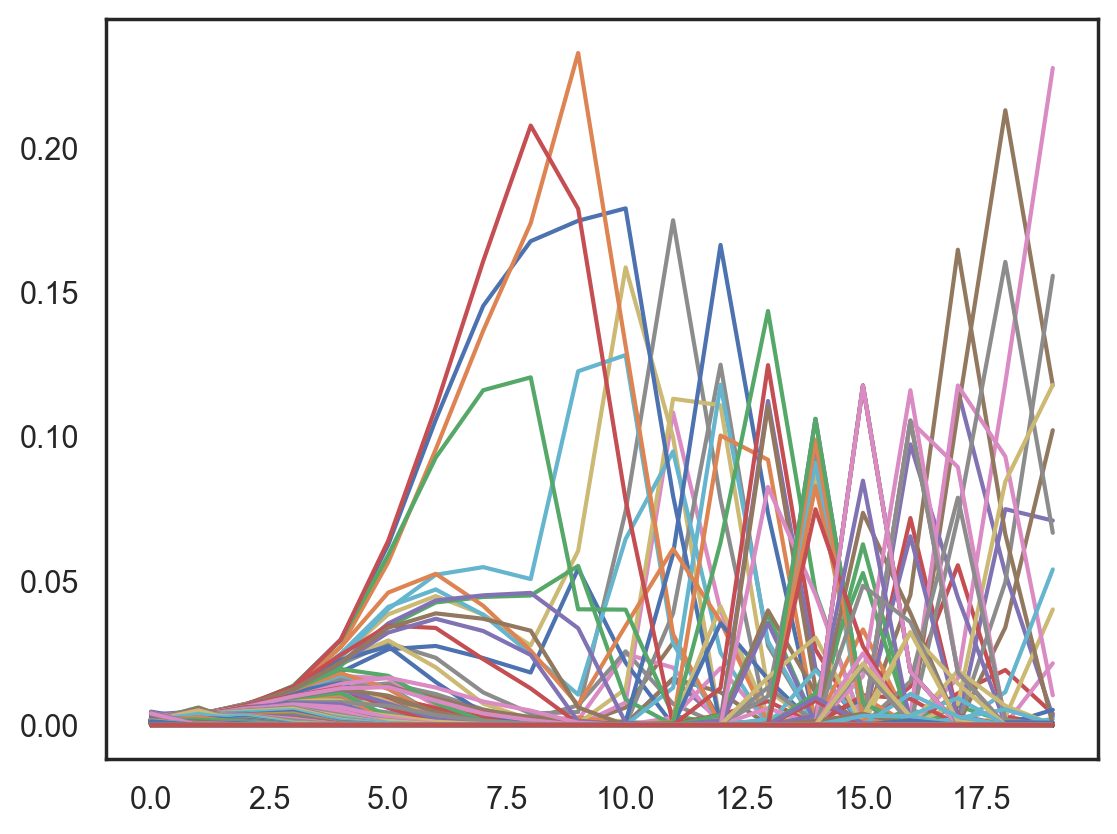

In [31]:
for state in range(n_state):
    plt.plot(hist_alpha[:, 5, state])

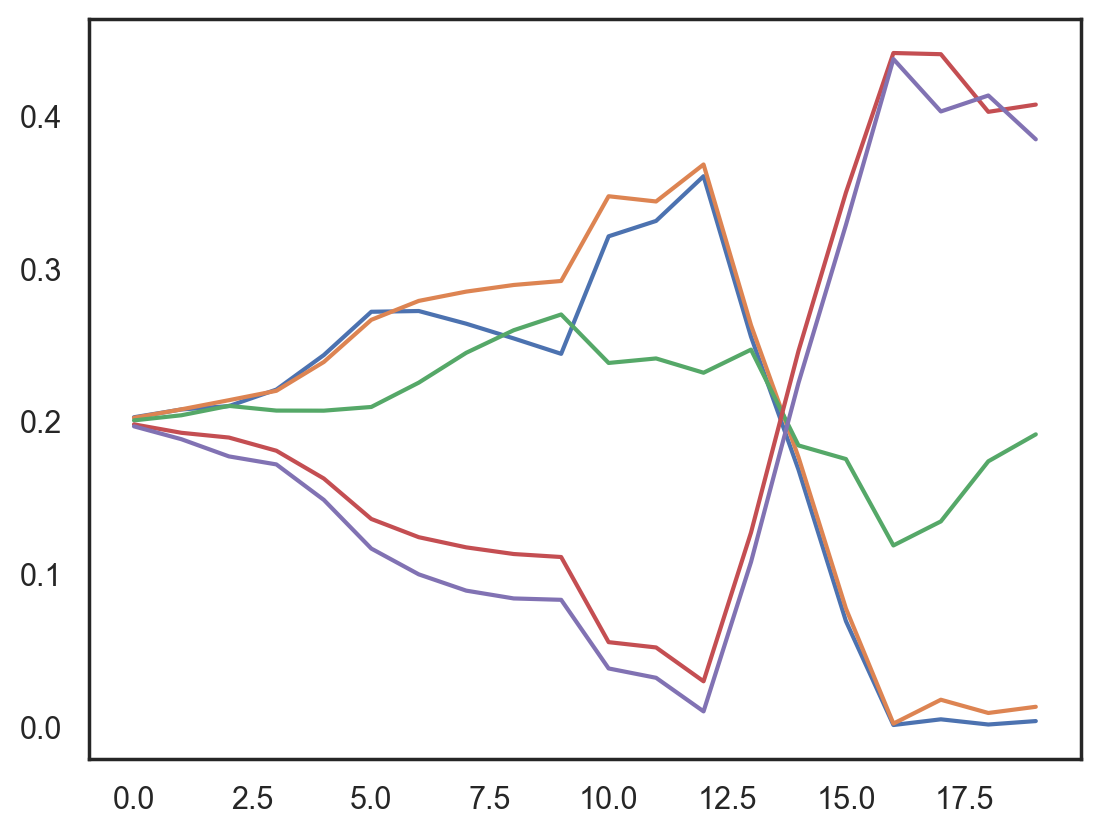

In [32]:
for action in range(n_action):
    plt.plot(hist_beta[:, 5, action])

## Alternative?

In [33]:
import torch
from tqdm import tqdm

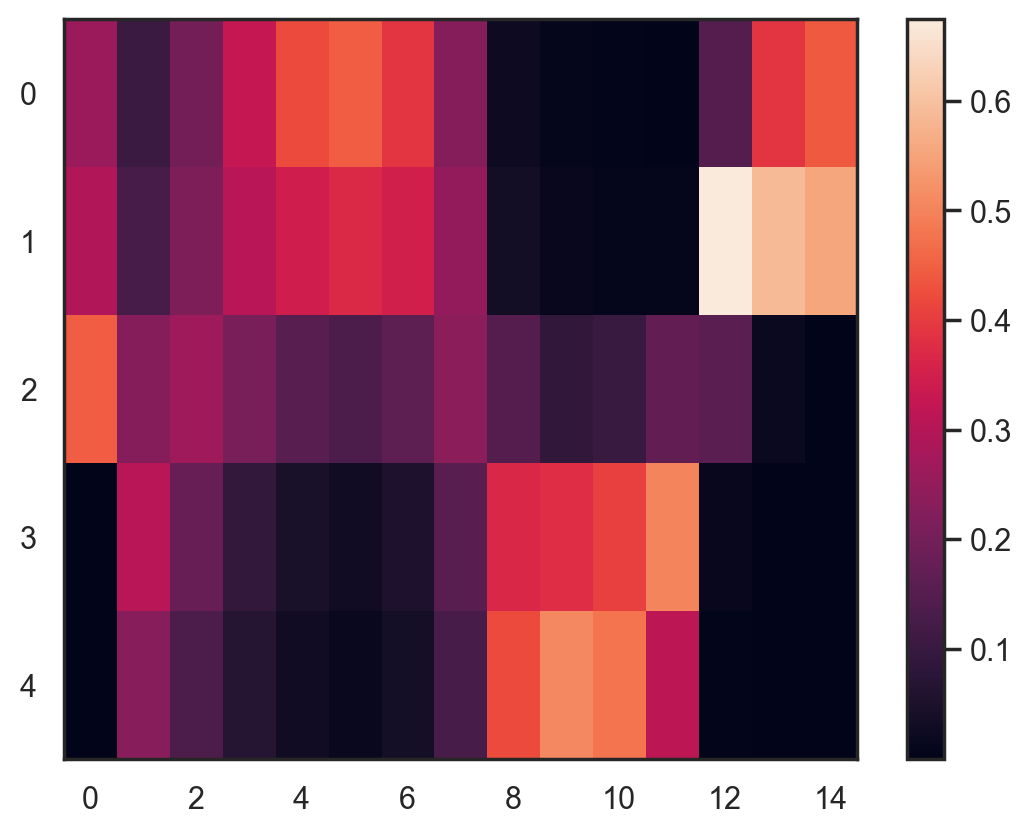

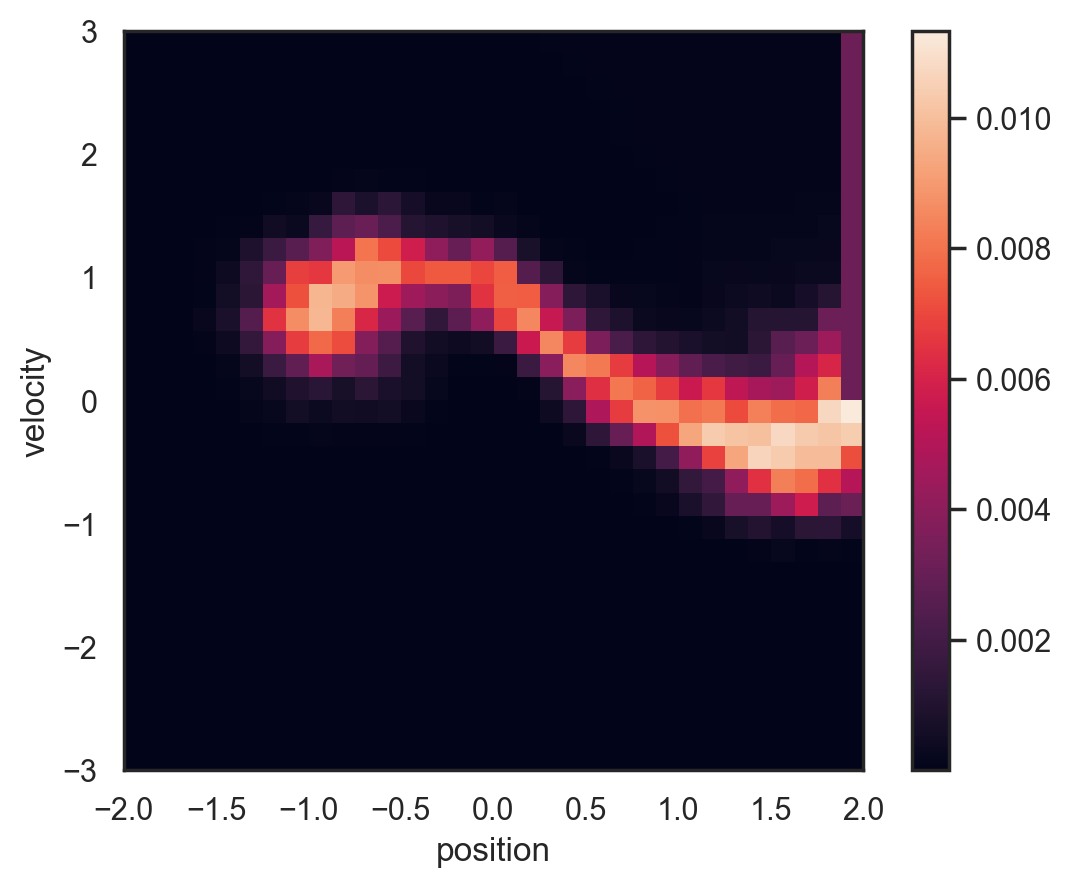

In [34]:
def normalize(q):
    q_sum = q.sum()
    if q_sum > 0:
        q /= q_sum
    return q

def safe_log(q):
    return np.log(np.maximum(q, 1e-16))

n_step = 16
n_epoch = 1000

coords = np.dstack(np.meshgrid(position_space, velocity_space)).reshape(-1, 2)
n_state = len(position_space) * len(velocity_space)
n_action = len(action_space)

tree = scipy.spatial.KDTree(coords)

goal = np.array([1.0, 0.0]) # goal = np.array([1.0, -1.0]) # goal = np.array([1.0, 0.0])
_, goal_idx = tree.query(goal)

starting = np.array([0.0, 0.0])
_, starting_idx = tree.query(starting)

starting_belief = np.zeros(n_state)
starting_belief[starting_idx] = 1.
starting_belief = torch.from_numpy(starting_belief).float()

tens_p_forward = torch.from_numpy(p_forward).float()

log_beta = torch.ones((n_step-1, n_action), requires_grad=True)
opt = torch.optim.Adam([log_beta, ], lr=0.1)
        
for epoch in tqdm(range(n_epoch), leave=False, desc="Epoch"):
    
    opt.zero_grad()
    
    # print(log_beta.requires_grad)
    
    beta = torch.softmax(log_beta - log_beta.max(), dim=1)
        
    beliefs = [starting_belief,]
    
    minus_ent_q=0
    
    for t in range(0, n_step-1):
        belief = beta[t]@(tens_p_forward@beliefs[-1])
        scaled_belief = belief / belief.sum()
        beliefs.append(scaled_belief)
        minus_ent_q += (beta[t]*torch.log(beta[t]+1e-16)).sum()
         
    minus_ent_q /= n_step-1
    
    px = beliefs[-1][goal_idx]
    elbo = torch.log(px+1e-16) - minus_ent_q
    loss  = -elbo
    
    loss.backward()
    opt.step()
        

# ------------------- #

fig, ax = plt.subplots()
im = ax.imshow(beta.detach().numpy().T, aspect="auto", interpolation='none')
fig.colorbar(im);

# fig, ax = plt.subplots()
# im = ax.imshow(beliefs[-1].detach().numpy().reshape((32, 32)), aspect="auto", interpolation='none')
# fig.colorbar(im);
plot_belief(beliefs[-1].detach().numpy(), cmap="rocket")  

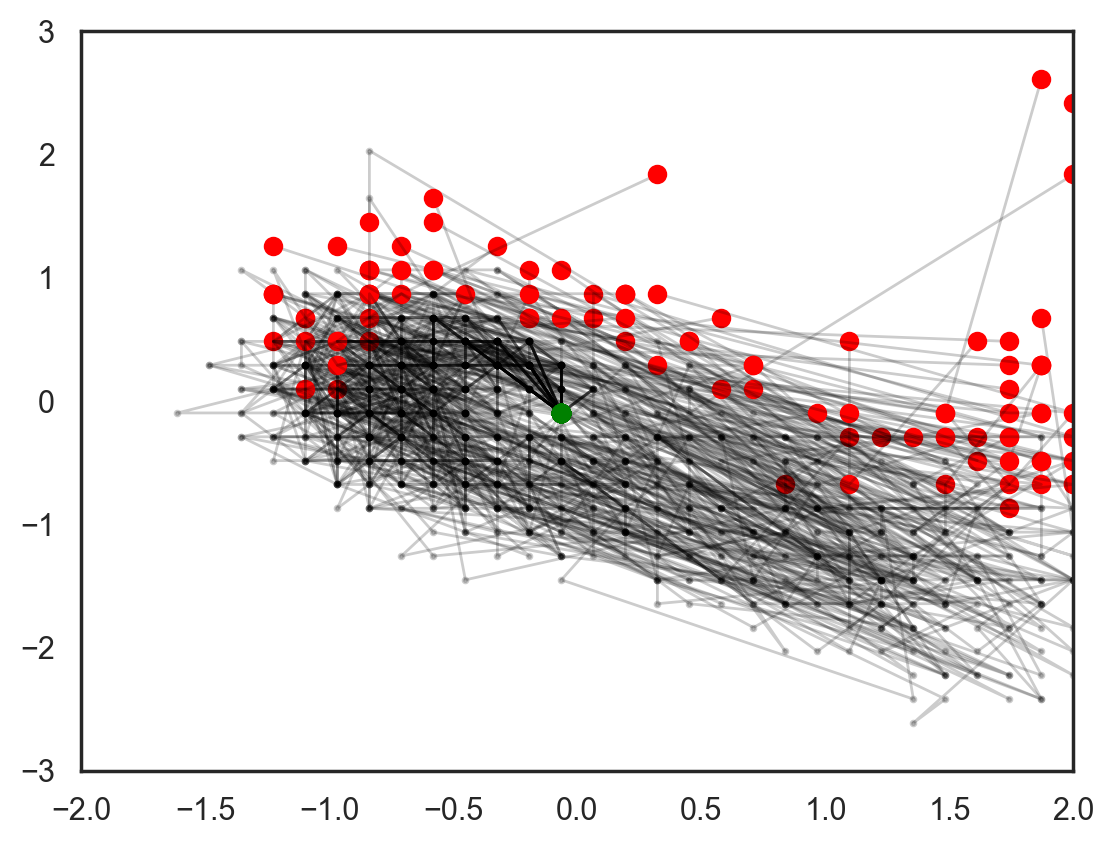

In [35]:
n_sample = 100

sample_trajectories = np.zeros((n_sample, n_step, 2))

for i in range(n_sample):
    for t in range(0, n_step):
        state_idx = np.random.choice(np.arange(n_state), p=beliefs[t].detach().numpy())
        sample_trajectories[i, t] = coords[state_idx]
    
    
# ------------------------------------------------- #

fig, ax = plt.subplots()
for i in range(n_sample):
    traj = sample_trajectories[i]
    ax.scatter(x=traj[:-1, 0], y=traj[:-1, 1], s=3, color="black", alpha=0.2)
    ax.plot(traj[:, 0], traj[:, 1], color="black", alpha=0.2, lw=1)
    x, y = traj[-1, :]
    ax.scatter(x=x, y=y, color="red", zorder=2)
    
    x, y = traj[0, :]
    ax.scatter(x=x, y=y, color="green", zorder=2)
    
ax.set_xlim(-2, 2)
ax.set_ylim(-3, 3);

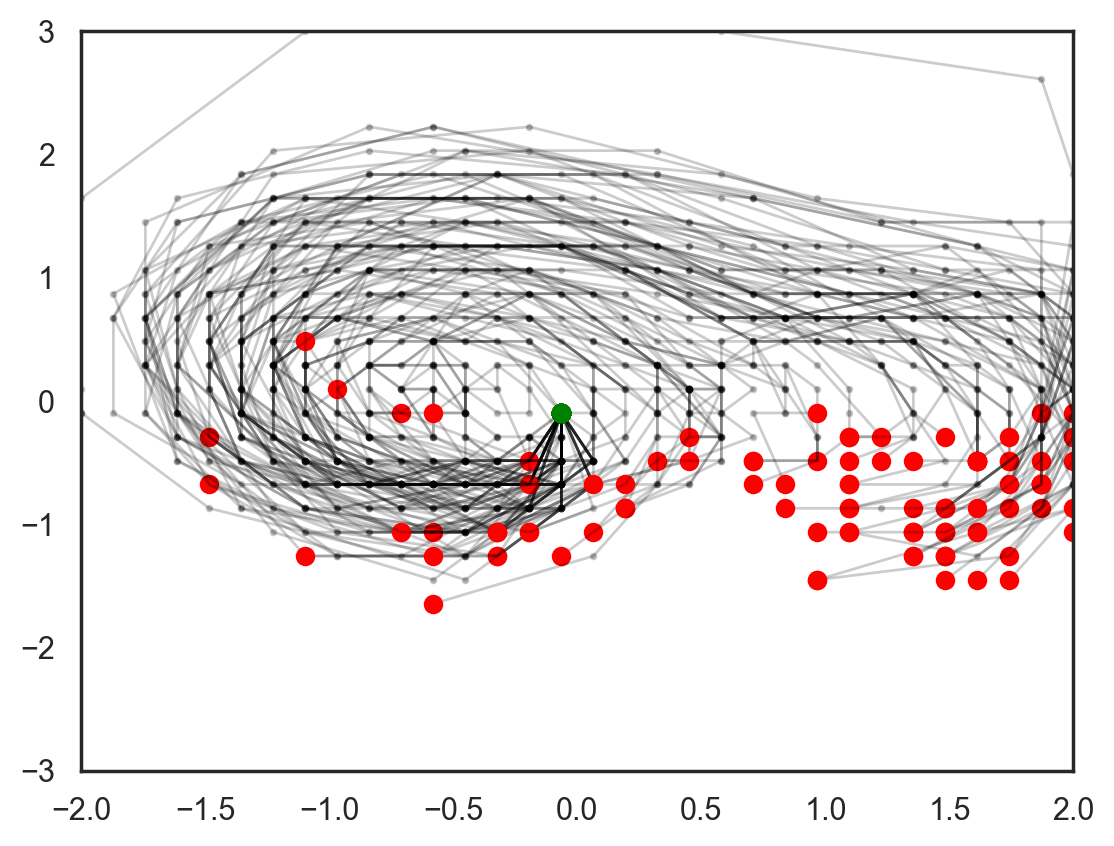

In [36]:
numpy_beta = beta.detach().numpy()

n_sample = 100

sample_trajectories = np.zeros((n_sample, n_step, 2))

for i in range(n_sample):
    
    for t in range(0, n_step):
        if t == 0:
            state_idx = starting_idx
        else:
            action_idx = np.random.choice(np.arange(n_action), p=numpy_beta[t-1])
            state_idx = np.random.choice(np.arange(n_state), p=p_forward[action_idx, state_idx, :]) 
        
        sample_trajectories[i, t] = coords[state_idx]
        
fig, ax = plt.subplots()
for i in range(n_sample):
    traj = sample_trajectories[i]
    ax.scatter(x=traj[:-1, 0], y=traj[:-1, 1], s=3, color="black", alpha=0.2)
    ax.plot(traj[:, 0], traj[:, 1], color="black", alpha=0.2, lw=1)
    x, y = traj[-1, :]
    ax.scatter(x=x, y=y, color="red", zorder=2)
    
    x, y = traj[0, :]
    ax.scatter(x=x, y=y, color="green", zorder=2)
    
ax.set_xlim(-2, 2)
ax.set_ylim(-3, 3);

## Exact inference 

In [78]:
delta_t = 1.
scale_gravity = 0.47
scale_friction = 0.49 # 0.04 # 0.125 # 1/8
scale_action = 0.25
scale_position = 0.44
position_space = np.linspace(-2, 2, 32)
velocity_space = np.linspace(-3, 3, 32)
action_space = np.arange(-2, 3) 
kernel = np.array([1/4, 1/2, 1/4]).reshape((-1,1))

def forward_motion(motion, action, delta_t, 
                   scale_gravity, scale_friction, scale_action, scale_position):
    
    position, velocity = motion

    force_action = scale_action * np.tanh(action)

    force_friction = -scale_friction * velocity

    if position <= 0:
        force_gravity = -2*position - 1
    else:
        a = (1 + 5*position**2)
        phi_2 = a**(-0.5)
        phi_3 = - 5*position**2*a**(-1.5)
        phi_4 = (position/2)**4 # negative of paper
        phi = phi_2 + phi_3 + phi_4
        # force_gravity = - position**2*(1+5*position**2)**(-3/2) - (1/8)*position**4
        # force_gravity = -(1+5*position**2)**(-3/2) - (1/8)*position**3
        force_gravity = -phi
        
    force_gravity *= scale_gravity # Scale it

    force = force_gravity + force_friction + force_action
    change_in_velocity = force
    change_in_position = scale_position*velocity

    if (velocity >= 3 and change_in_velocity > 0) \
            or (velocity <= -3 and change_in_velocity < 0):
        change_in_velocity = 0

    if (position <= -2 and change_in_position < 0) \
            or (position >= 2 and change_in_position > 0):
        change_in_position = 0
        change_in_velocity = - velocity # zeroing out velocity
    
    position += change_in_position
    velocity += change_in_velocity
    
    position = np.clip(position, -2, 2)
    velocity = np.clip(velocity, -3, 3)
    return np.array([position, velocity])

coords = np.dstack(np.meshgrid(position_space, velocity_space)).reshape(-1, 2)
n_state = len(position_space) * len(velocity_space)
n_action = len(action_space)   

p_forward = np.zeros((n_action, n_state, n_state))

tree = scipy.spatial.KDTree(coords)

for idx_act in range(n_action):
    for idx, coord in enumerate(coords):
        
        act = action_space[idx_act]
        
        expected_motion = forward_motion(
            motion=coord,
            action=act, 
            delta_t=delta_t,
            scale_gravity=scale_gravity,
            scale_friction=scale_friction,
            scale_action=scale_action,
            scale_position=scale_position)
        
        dist, idx_closest = tree.query(expected_motion)
        
        s = np.zeros(n_state)
        s[idx_closest] = 1.
        
        # Do the convolution
        s = s.reshape((len(position_space), len(velocity_space)))
        s = scipy.signal.convolve(s, kernel, mode="same")
        s = scipy.signal.convolve(s, kernel.T, mode="same")
        s = s.ravel()
        
        p_forward[idx_act, idx, :] =  s
        p_forward[idx_act, idx, :] /= p_forward[idx_act, idx, :].sum()
        
p_backward = np.zeros_like(p_forward)
for idx_act in range(n_action):
    p_backward[idx_act] = p_forward[idx_act]
    for idx in range(n_state):
        bwd_sum = p_backward[idx_act, :, idx].sum()
        if bwd_sum > 0:
            p_backward[idx_act, :, idx] /= bwd_sum # Normalize

t 14 s0 [1.1875, -0.65625] a 2 s1 [0.9375, -0.09375] message -10.073423316741378 argument -10.073423316741378 validation -10.073423316741378
t 13 s0 [1.6875, -1.21875] a 2 s1 [1.1875, -0.65625] message -19.845719563940328 argument -19.845719563940328 validation -19.845719563940328
t 12 s0 [1.9375, -0.65625] a -2 s1 [1.6875, -1.21875] message -28.41404300681334 argument -28.41404300681334 validation -28.41404300681334
t 11 s0 [1.9375, -0.28125] a 1 s1 [1.9375, -0.65625] message -36.576901341578186 argument -36.576901341578186 validation -36.576901341578186
t 10 s0 [-1.9375, 0.28125] a 0 s1 [-1.9375, 1.78125] message -45.87315104649688 argument -45.87315104649688 validation -45.87315104649688
t 9 s0 [-1.9375, 0.28125] a 0 s1 [-1.9375, 1.78125] message -56.11545092294156 argument -56.11545092294156 validation -56.11545092294156
t 8 s0 [-0.4375, -2.90625] a 1 s1 [-1.8125, -1.59375] message -64.71958381851128 argument -64.71958381851128 validation -64.71958381851128
t 7 s0 [-1.5625, 2.90625

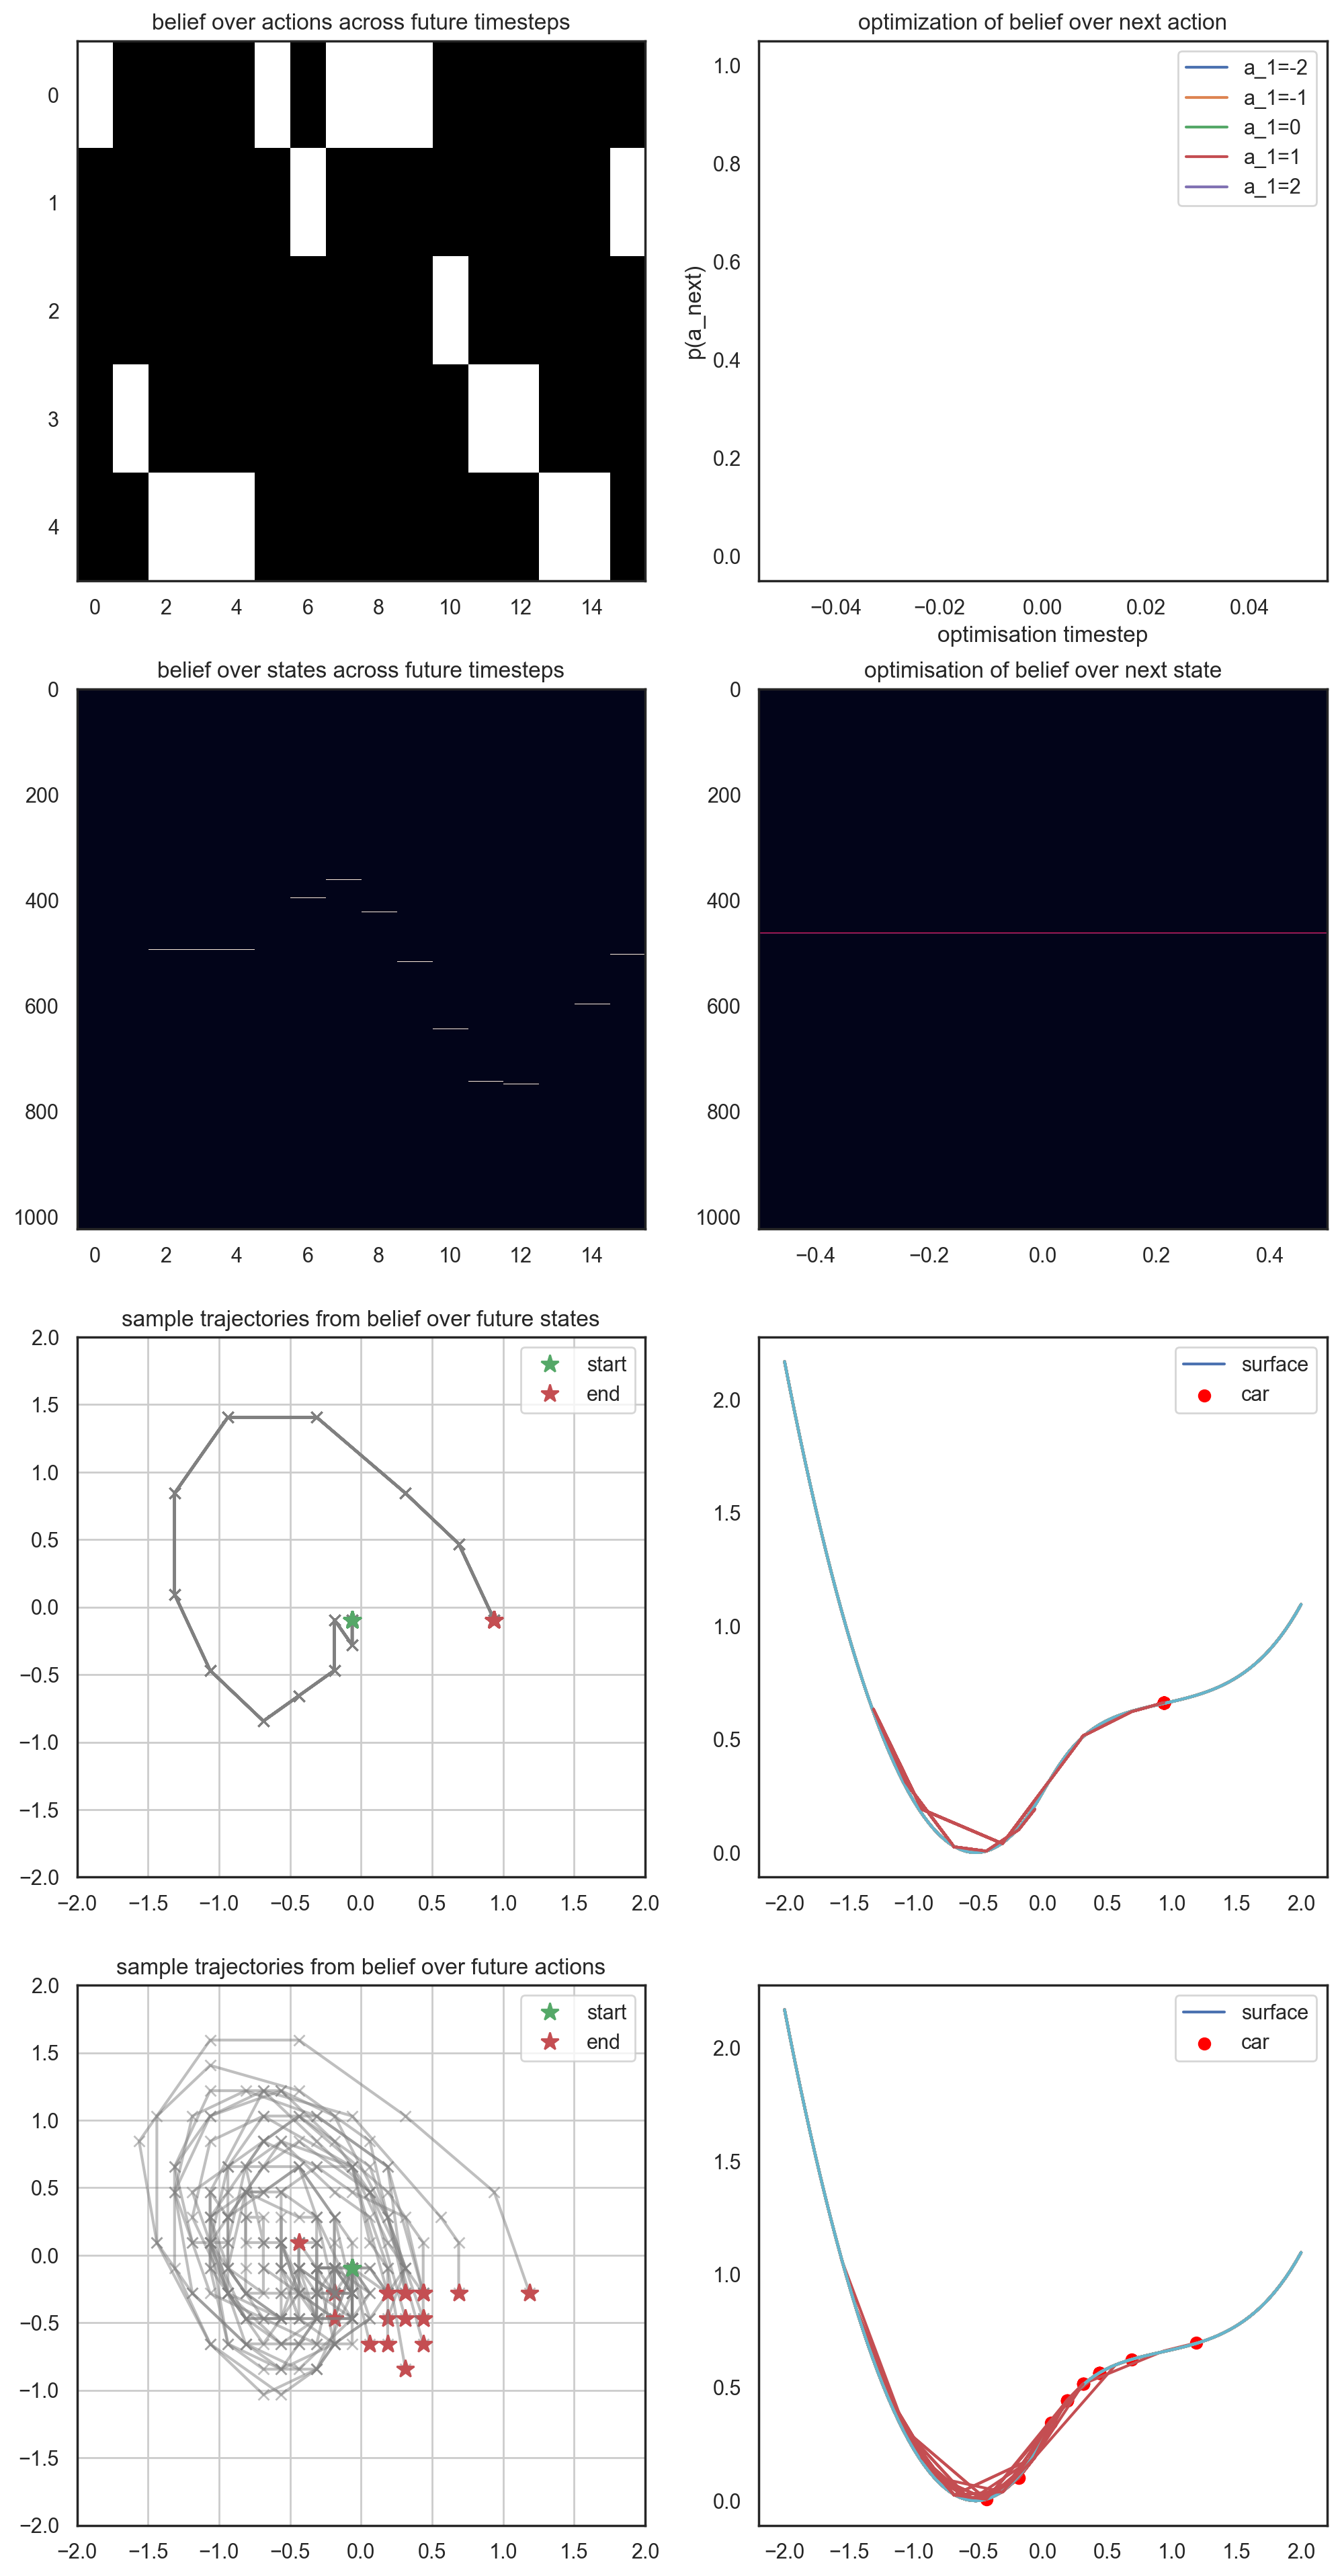

In [79]:
import scipy
import numpy as np
from collections import namedtuple
import matplotlib.pyplot as plt

p_back = p_backward #np.load('p_backward.npy')

n_x, n_v = 32, 32
n_s = n_x * n_v
bounds_x = np.array([-2,2])
bounds_v = np.array([-3,3])
cell_x = (bounds_x[1]-bounds_x[0])/n_x
cell_v = (bounds_v[1]-bounds_v[0])/n_v

def index(x, bounds, nbins):
    r = (bounds[1]-bounds[0]) + 1e-6
    idx = ((x-bounds[0])/r*nbins).astype(int)
    return idx

def value(idx, bounds, nbins):
    r = (bounds[1]-bounds[0])
    w = r / nbins
    return float(idx)/nbins * r + bounds[0] +w/2

def index_x(x):
    return index(x, bounds_x, n_x)

def value_x(x):
    return value(x, bounds_x, n_x)

def index_v(v):
    return index(v, bounds_v, n_v)

def value_v(v):
    return value(v, bounds_v, n_v)

def idx_s_from_idx_xv(x, v):
    return v * n_x + x

def idx_xv_from_idx_s(s):
    x = s % n_x
    v = (s-x) / n_x
    return [int(x), int(v)]

def s_from_index_s(i_s):
    i_x, i_v = idx_xv_from_idx_s(i_s)
    return [value_x(i_x), value_v(i_v)]

def index_s_from_s(s):
    return idx_s_from_idx_xv(index_x(s[0]), index_v(s[1]))


def s1_given_s_a(s, a, debug=False, use_ivp=True):
    if use_ivp:
        sol = scipy.integrate.solve_ivp(f, t_span=[0.0, 0.5], y0=s, rtol=1e-6, vectorized=True,
                                        args=(a,))  # Fig 5: [0, 0.5] with zero action start
    else:
        dt = 0.6
        ds = f(None, np.array(s)[:, np.newaxis], a)
        sol = namedtuple('sol', 'y')
        sol.y = (np.array(s) + ds.squeeze() * dt).reshape((-1, 1))

    if debug:
        return sol

    return sol.y[:, -1]


def f_friction(v):
    return -1 / 4 * v

def f_action(a):
    return np.tanh(a)


def f(t, s, a):
    dx = s[1]
    f_a = f_action(a)
    f_g = f_gravity(s[0])
    f_i = f_friction(s[1])
    dv = f_a + f_g + f_i
    # print(f't {t:.2f}, s {s[0,0]:.2f}, {s[1,0]:.2f}, a {a:.2f}, fa {f_a:.2f}, fg {f_g[0]:.2f}, fi {f_i[0]:.2f}')
    return np.array([dx, dv])


def f_gravity(x):
    phi = np.zeros_like(x)
    is_leq0 = x <= 0
    phi_1 = 2 * x + 1
    a = (1 + 5 * x ** 2)
    phi_2 = a ** (-0.5)
    phi_3 = - 5 * x ** 2 * a ** (-1.5)
    phi_4 = (x / 2) ** 4  # negative of paper
    phi = phi_2 + phi_3 + phi_4
    phi[is_leq0] = phi_1[is_leq0]
    return -phi


N = 101
x = np.linspace(-2, 2, N)
g = f_gravity(x)
w = 4 / N
h = np.cumsum(-g) * w
h -= h.min()

s0 = [-0.06451613, -0.09677419]
aa_fig4 = [4, 4, 3, 2, 2, 1, 1, 2, 3, 3, 3, 1, 2, 1, 2]
# , 4, 4, 3, 2, 2, 2, 2, 2, 3, 3, 2, 1, 2, 1, 2]
aa_fig5 = [2, 1, 1, 3, 3, 3, 2, 2, 3, 1, 2, 2, 2, 2, 2, 1]  # [2, 1, 1, 3, 3, 3, 2, 2, 3, 1, 2, 2, 2, 2, 2, 1]

aa = aa_fig5
a = [-2, -1, 0, 1, 2]
aa = [a[x] for x in aa]

ss = [s0]
ss_full = [s0]
for a in aa:
    sol = s1_given_s_a(s=ss[-1], a=a, debug=True)
    ss.append(sol.y[:, -1])
    ss_full.extend(sol.y.T.tolist())


def normalize(p_transition, mode='column'):
    # sum over elements in each row, shaped to normalize correctly
    row_norm = lambda x: np.maximum(x.sum(axis=1).reshape((-1, 1)), 1e-6)
    # sum over elements in each column, shaped to normalize correctly
    column_norm = lambda x: np.maximum(x.sum(axis=0), 1e-6)

    if mode == 'column':
        # print('normalize for each column to sum to 1.')
        norm = column_norm
    else:
        # print('normalize for each row to sum to 1.')
        norm = row_norm

    if len(p_transition.shape) > 2:
        # print('interpreting axis 0 as action, normalizing each 2D subtensor')
        for a_i in range(p_transition.shape[0]):
            # normalize column-wise
            p = p_transition[a_i]
            l1 = norm(p)
            p = p / l1
            p_transition[a_i] = p

        return p_transition

    else:
        l1 = norm(p_transition)
        return p_transition / l1


def height(state):
    pos = np.clip(state[0], x[0], x[-1])
    r = x[-1] - x[0] + 1e-6
    i_x = int((pos - x[0]) / r * N)
    # print(pos, r, i_x, h[i_x])
    return h[i_x]


def plot_trajectory(states, ax=None, color=None, alpha=1, label=None, legend=True):
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(2 * 10, 5))

    xx = [s[0] for s in states]
    vv = [s[1] for s in states]
    hh = np.array([height(s) for s in states])
    hh += np.linspace(0, 1, hh.shape[0]) * 0.00

    plt.sca(ax[0])
    plt.plot(xx, vv, 'x-', label=label, color=color, alpha=alpha)
    plt.plot([xx[0]], [vv[0]], 'g*', ms=10, label='start')
    plt.plot([xx[-1]], [vv[-1]], 'r*', ms=10, label='end')
    plt.xlim([-2, 2])
    plt.ylim([-2, 2])
    plt.title('state transition')
    plt.grid('on')
    if legend:
        plt.legend()

    plt.sca(ax[1])
    plt.plot(x, h, label='surface')
    plt.plot(xx, hh, 'r-')
    plt.scatter([xx[-1]], [hh[-1]], color='red', marker='o', label='car')
    if legend:
        plt.legend()


def show_inference_result(bb_a, bb_s):
    t = 1
    n_samples = 20  # sample tranjectories from beliefs
    n_rows, n_cols = 4, 2
    p_forward = normalize(p_backward, mode='rows')

    fig, ax = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 6 * n_rows))

    # explore actions
    # show belief over sequence of actions at convergence
    cax = ax[0][0]
    plt.sca(cax)
    plt.imshow(bb_a[-1].T, cmap='gray', aspect='auto')
    cax.set_title('belief over actions across future timesteps');

    # show convergence of belief over actions at one timestep
    cax = ax[0][1]
    plt.sca(cax)
    for a_i in range(n_a):
        plt.plot(np.array(bb_a)[:, t, a_i], label=f'a_{t}={[-2, -1, 0, 1, 2][a_i]}')
    cax.set_title('optimization of belief over next action');
    plt.xlabel('optimisation timestep')
    plt.ylabel('p(a_next)')
    plt.legend()

    # explore states
    # show belief over sequence of states at convergence
    cax = ax[1][0]
    plt.sca(cax)
    plt.imshow(np.array(bb_s)[-1, :, :].T, aspect='auto', interpolation='nearest')
    cax.set_title('belief over states across future timesteps');

    # show convergence of belief over states at one timestep
    cax = ax[1][1]
    plt.sca(cax)
    plt.imshow(np.array(bb_s)[:, t, :].T, aspect='auto', interpolation=None)
    cax.set_title('optimisation of belief over next state');

    # illustrate sequence of most likely states in phase space
    # sample trajectories from belief over future states
    cax = ax[2][0]
    for i in range(n_samples):
        ss = np.array([s_from_index_s(np.random.choice(range(n_s), p=np.array(bb_s)[-1, t, :])) for t in range(T)])
        plot_trajectory(ss, ax=[ax[2][0], ax[2][1]], legend=i == 0, color='gray', alpha=0.5)
    cax.set_title('sample trajectories from belief over future states');

    # sample trajectories from belief over future actions
    cax = ax[3][0]
    for i in range(n_samples):
        s_i = index_s_from_s([0, 0])
        ss = [s_from_index_s(s_i)]

        for t in range(1, T):
            a_i = np.random.choice(range(n_a), p=bb_a[-1][t])
            # _i = np.random.choice(range(n_a))
            p_s_i = p_forward[a_i, s_i, :]
            s_i = np.random.choice(n_s, p=p_s_i)
            ss.append(s_from_index_s(s_i))

        plot_trajectory(ss, ax=[ax[3][0], ax[3][1]], legend=i == 0, color='gray', alpha=0.5)

    cax.set_title('sample trajectories from belief over future actions');


T = 16  # planning horizon
n_a = p_backward.shape[0]
aa = np.array([-2, -1, 0, 1, 2], dtype=int)


def slog(x):
    # save log
    sx = np.maximum(x, 1e-6)
    return np.log(sx / sx.sum())


# 1. compute all priors
ln_pa = slog(1 / n_a)
prior_s0 = np.eye(n_s)[index_s_from_s([0, 0])]
ln_p0 = slog(prior_s0)
prior_sT = np.eye(n_s)[index_s_from_s([1, 0])]
ln_pT = slog(prior_sT)
ln_p = slog(p_back)

msg_s_right = np.zeros((T, n_s))
msg_s_right[-1] = ln_pT
backtrack_a = np.zeros((T, n_s), dtype=int)
backtrack_s = np.zeros((T, n_s), dtype=int)

# forward pass
for t in reversed(range(T - 1)):
    arg = ln_p + msg_s_right[t + 1] + ln_pa
    # take max over action only
    max_a = np.max(arg, axis=0)
    # identify next state associated with the maximum for each s0
    argmax_s1 = np.argmax(max_a, axis=1)  # backtracking s1
    # take max over next state only
    max_s1 = np.max(arg, axis=2)
    # identify action associated with the maximum for each s0
    argmax_a = np.argmax(max_s1, axis=0)  # backtracking a
    # take max over both state and action
    max_a_s1 = np.max(max_a, axis=1)  # outgoing message
    # debug only: identify max s0
    argmax_s0 = np.argmax(max_a_s1)

    msg_s_right[t] = max_a_s1
    backtrack_a[t] = argmax_a
    backtrack_s[t] = argmax_s1

    print('t', t,
          's0', s_from_index_s(argmax_s0),
          'a', aa[argmax_a[argmax_s0]],
          's1', s_from_index_s(argmax_s1[argmax_s0]),
          'message', max_a_s1[argmax_s0],
          'argument', arg[argmax_a[argmax_s0], argmax_s0, argmax_s1[argmax_s0]],
          'validation', arg.max())

print("Backtracking")

# backtracking
s0 = [0, 0]  # initial state
s0_i = index_s_from_s(s0)  # index of initial state
eye_s = np.eye(n_s)
eye_a = np.eye(n_a)

ss_i = [s0_i]
print(s_from_index_s(ss_i[-1]))
aa_i = [0]
for t in range(T - 1):
    a_next = backtrack_a[t, ss_i[-1]]
    s_next = backtrack_s[t, ss_i[-1]]
    ss_i.append(s_next)
    aa_i.append(a_next)
    print('action', a_next, 'next state', s_from_index_s(s_next))

bb_s = np.array([[eye_s[s_i] for s_i in ss_i]])
bb_a = np.array([[eye_a[a_i] for a_i in aa_i]])

show_inference_result(bb_a, bb_s)